In [8]:
from __future__ import division, print_function, absolute_import
import os
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from config import pathDict
from conv_net.train import Train, TrainConvEnc
from conv_net.test import Test
from data_transformation.data_prep import get_valid_land_house_ids, dumpStratifiedBatches_balanced_class
from plot import Plot

%matplotlib inline
sns.set_style("whitegrid")


imp_image_shape = [224,400,3]
crop_shape = [128,128,3]
output_img_shape = [64,64,3]

which_net = 'autoencoder'
batch_prepare = True
train = True
test = True

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot import Plot
sns.set_style("whitegrid")

# PREPARE BATCHES
------

In [10]:
start_time = time.time()
assessor_code_house_path = pathDict['assessor_code_house_path']
assessor_code_land_path = pathDict['assessor_code_land_path']

cmn_house_pins = [pin.split('.')[0] for pin in os.listdir(assessor_code_house_path) if pin != '.DS_Store']

cmn_land_pins = [pin.split('.')[0] for pin in os.listdir(assessor_code_land_path) if pin != '.DS_Store']

if batch_prepare:
    tr_batch_size = 128
    ts_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    dumpStratifiedBatches_balanced_class(cmn_land_pins=cmn_land_pins, 
                                         cmn_house_pins=cmn_house_pins, 
                                         img_resize_shape=[250, 300, 3],
                                         image_type='assessor_code',
                                         ts_batch_size=ts_batch_size,
                                         cv_batch_size=cv_batch_size,
                                         tr_batch_size=tr_batch_size,
                                         shuffle_seed=873,
                                         get_stats=True,
                                         max_batches=None)
print ('--------------- %s seconds ------------------'%(time.time() - start_time))

--------------- 18.366037130355835 seconds ------------------


# EVALUATE MODELS:
----------

# MODEL 1 : 

#### Clearly overfilts, because the data is pretty small and the model is way too complex.

* img_shape  = [64x64x3]
* conv_filter = [3,16,32,64,128]
* dconv_filter = [128,64,32,16,3]

Dumping Checkpoints to %s C:\Users\newline\Documents\ImageClassification\data\data_models\assessor_code_images\checkpoint\autoencoder
Dumping Tensorboard Summary to %s C:\Users\newline\Documents\ImageClassification\data\data_models\assessor_code_images\summary\autoencoder
(?, 4, 4, 256)
Learning Rate: Initial:  0.01
Checkpoint latest at:  C:\Users\newline\Documents\ImageClassification\data\data_models\assessor_code_images\checkpoint\autoencoder\autoencoder_epoch_12_batch_2
cvalid_shape:  (60, 224, 400, 3)


C:\Anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


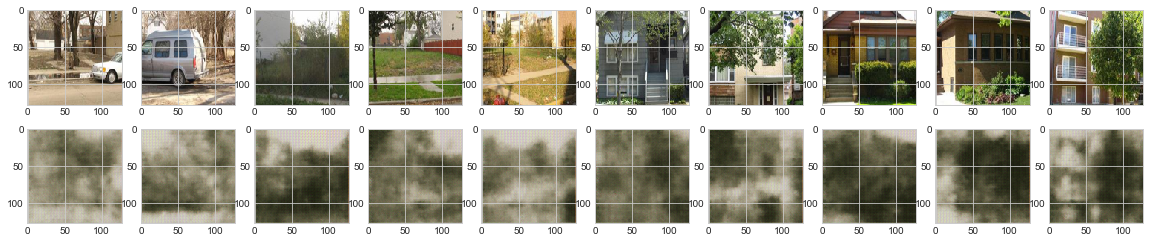

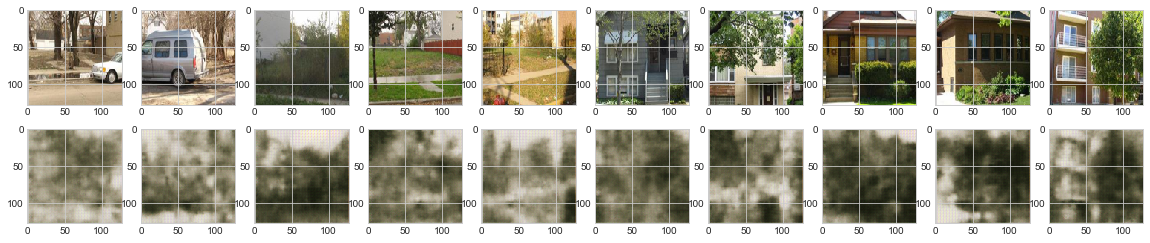

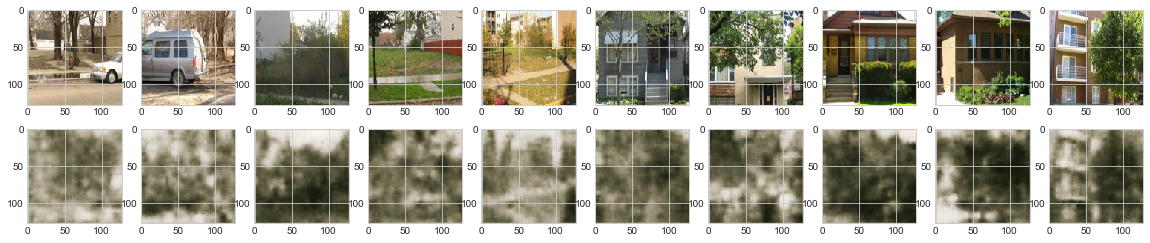

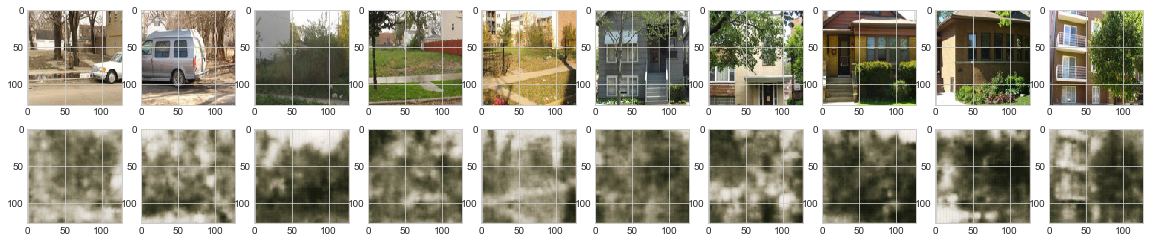

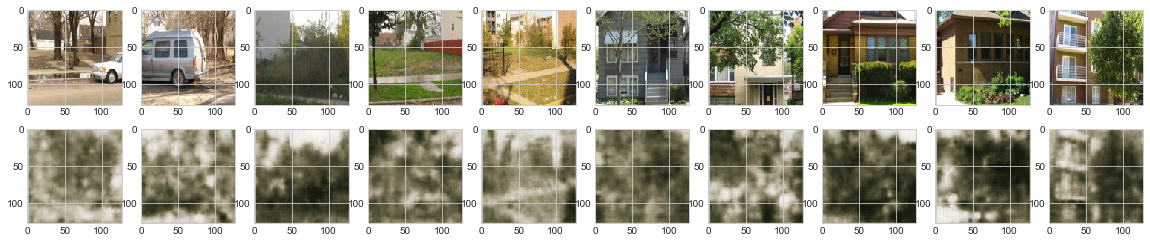

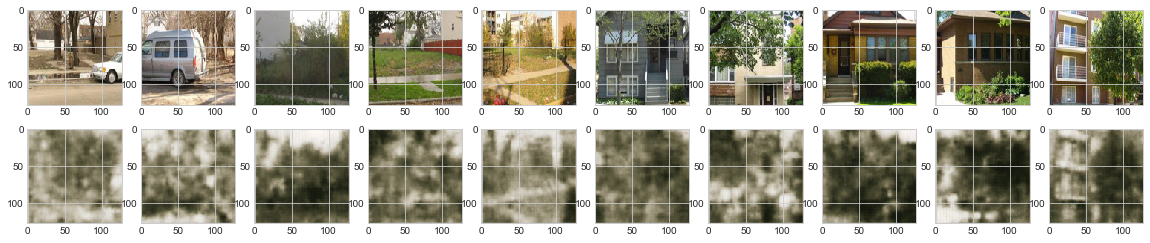

In [3]:
max_batches = 2

if train:
    tr_obj = TrainConvEnc(dict(inp_img_shape=[224, 400, 3],
                            crop_shape=[128, 128, 3],
                            out_img_shape=[128, 128, 3],
                            use_checkpoint=True,
                            save_checkpoint=True,
                            write_tensorboard_summary=False
                            ),
                       device_type='gpu',
                       which_net='autoencoder',  # vgg
                       image_type='assessor_code')
    (tr_loss_arr, cv_loss_arr, l_rate_arr, cv_reconstruction_mse,
     cv_reconstruction_entropy, cvY_label) = tr_obj.run(num_epochs=500, num_batches=max_batches+1, get_stats_at=100,
                                                        plot=True)  # + 1)
    
    reconsMSE_DF = pd.DataFrame({'labels':cvY_label, 'reconstruction_mse': cv_reconstruction_mse})
    reconsENT_DF = pd.DataFrame({'labels':cvY_label, 'reconstruction_ent': cv_reconstruction_entropy})

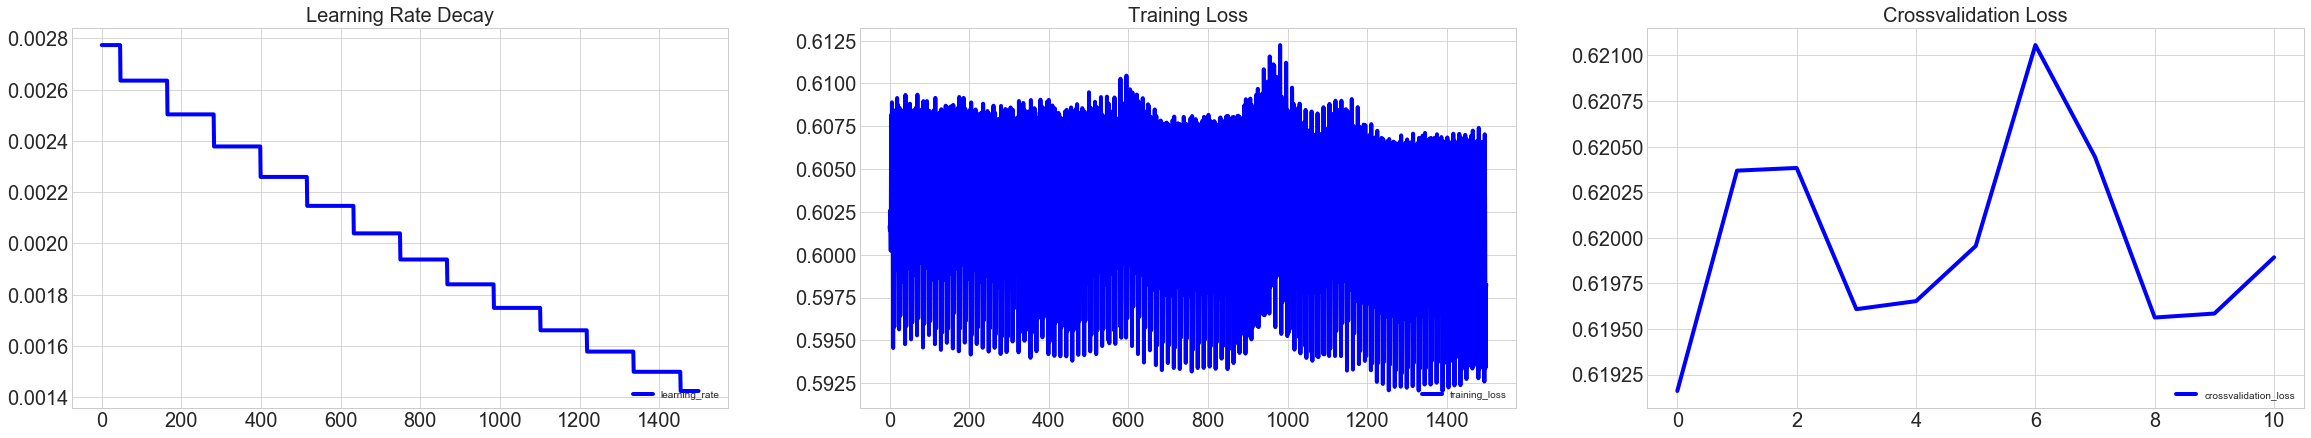

In [22]:
oj = Plot(rows=1, columns=3, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})

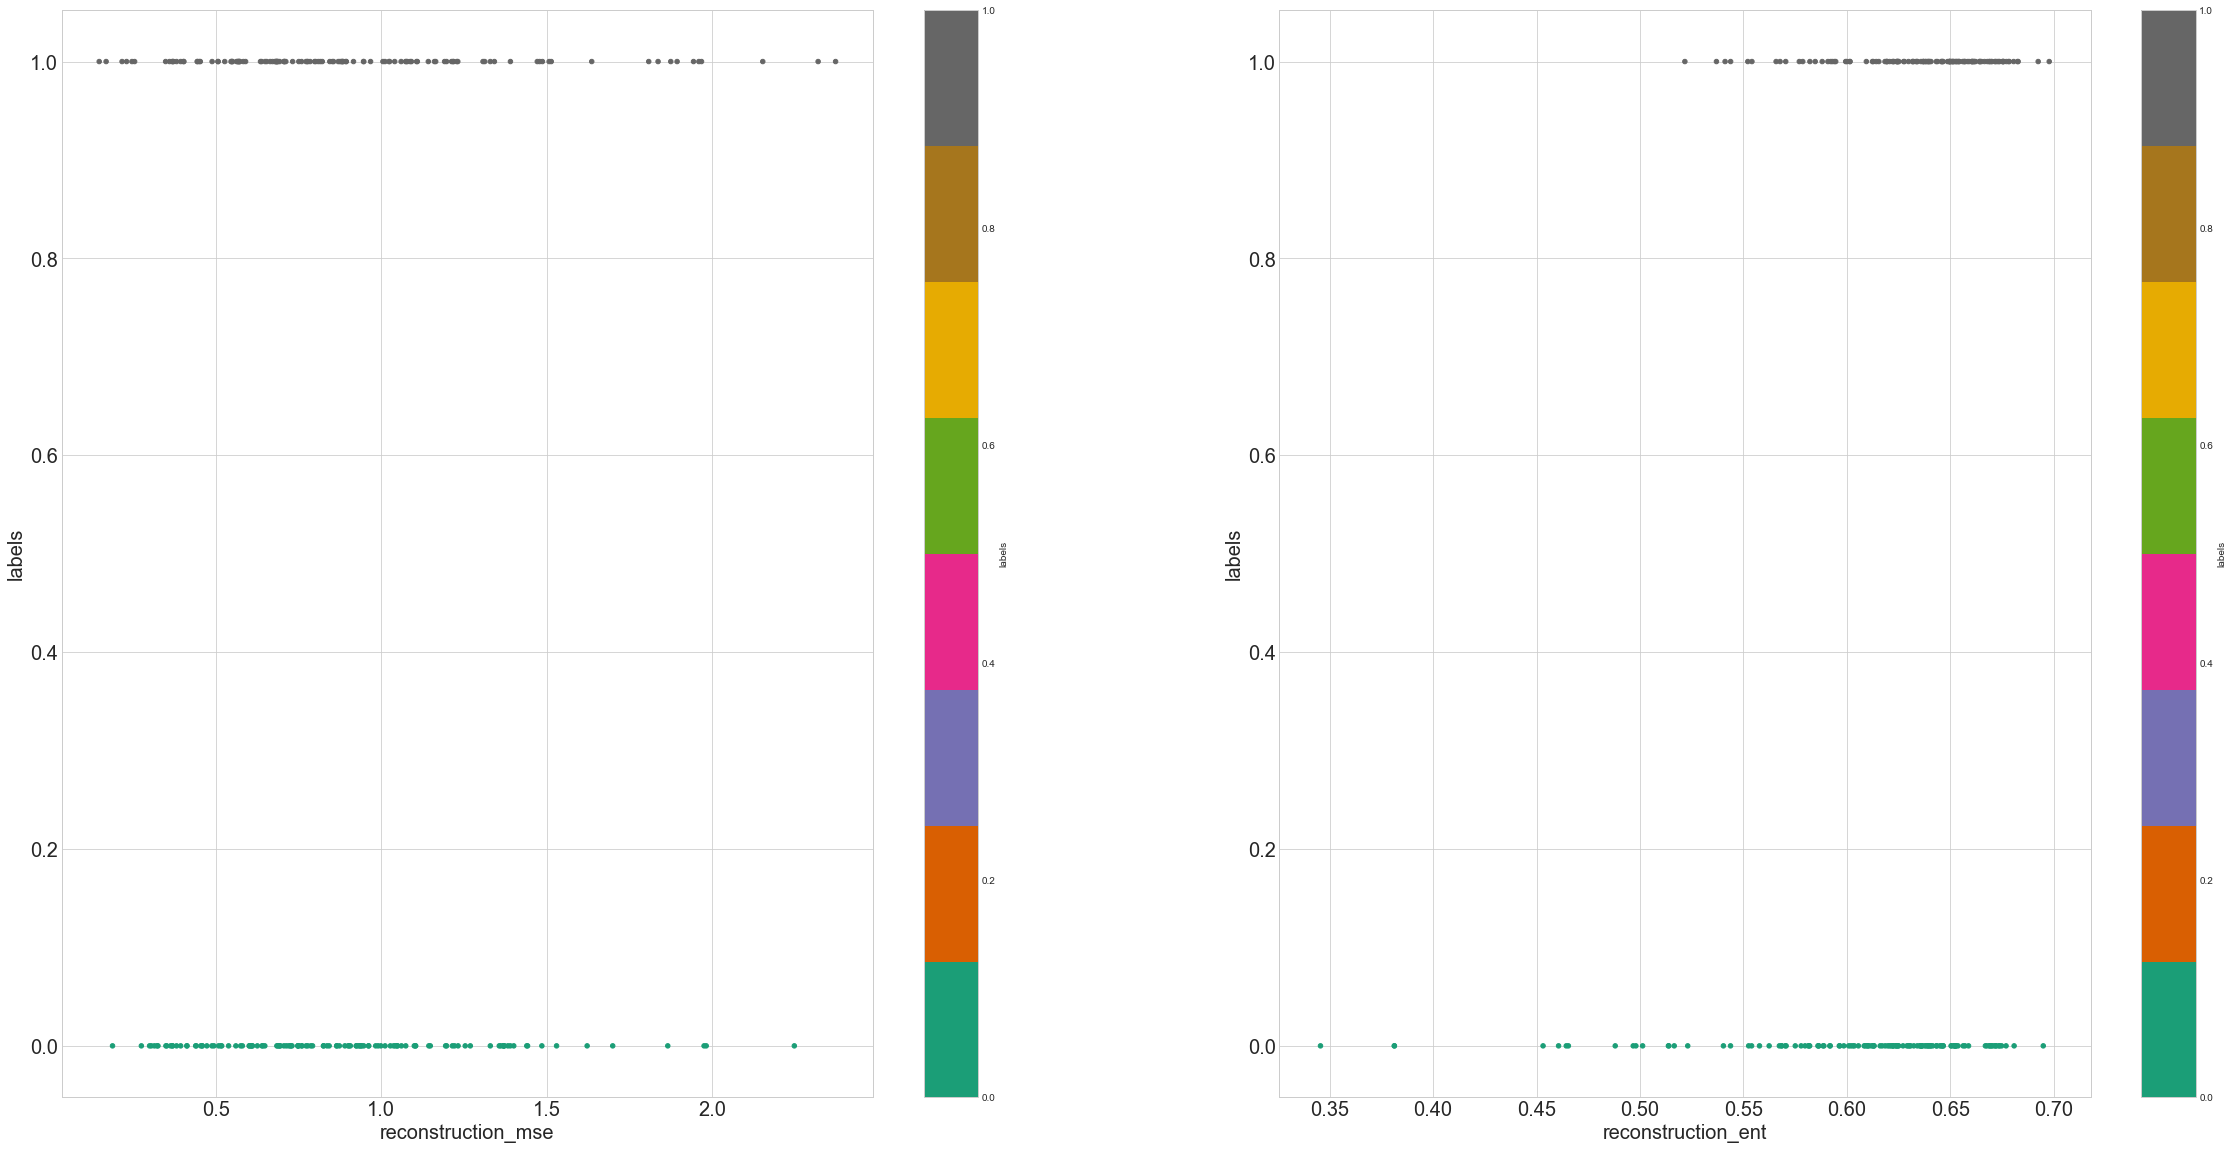

In [23]:
obj_plt = Plot(1,2,(40,20))
obj_plt.vizualize(reconsMSE_DF, colX='reconstruction_mse', colY='labels', label_col='labels', viz_type='scatter')
obj_plt.vizualize(reconsENT_DF, colX='reconstruction_ent', colY='labels', label_col='labels', viz_type='scatter')
# reconsMSE_DF.plot.scatter(x='labels', y='reconstruction_mse', c='labels', colormap='Dark2', ax=axs)

# MODEL 2:
-------------
Model 1 +
* Increase the dataset to 1250 images each land and house.
* Out of these 125 are test data snd 125 are cross validation data 

Doesn't overfit, but clearly there is no pattern in the reconstruction MSE to separate the land and house images. So the next approach would be to try out:
  * Make the encoder layer to have 16 - 32 filters. and then try doing a Kmeans Clustering or Gaussian process, becasue we know there are two class.
  * Try training with only few dataset, generate 128 dimension encoding with Autoencoder and then try classifying with a more shopisticated Machine learning model such as SVM (Linear SVC)

In [4]:
max_batches = 14

if train:
    tr_obj = TrainConvEnc(dict(learning_rate=0.01,
                            inp_img_shape=[224, 400, 3],
                            crop_shape=[128, 128, 3],
                            out_img_shape=[128, 128, 3],
                            use_checkpoint=True,
                            save_checkpoint=True,
                            write_tensorboard_summary=False
                            ),
                       device_type='gpu',
                       which_net='autoencoder',  # vgg
                       image_type='assessor_code')
    (tr_loss_arr, cv_loss_arr, l_rate_arr, cv_reconstruction_mse,
     cv_reconstruction_entropy, cvY_label) = tr_obj.run(num_epochs=100, num_batches=max_batches+1, get_stats_at=20,
                                                        plot=True)  # + 1)
    
    reconsMSE_DF = pd.DataFrame({'labels':cvY_label, 'reconstruction_mse': cv_reconstruction_mse})
    reconsENT_DF = pd.DataFrame({'labels':cvY_label, 'reconstruction_ent': cv_reconstruction_entropy})

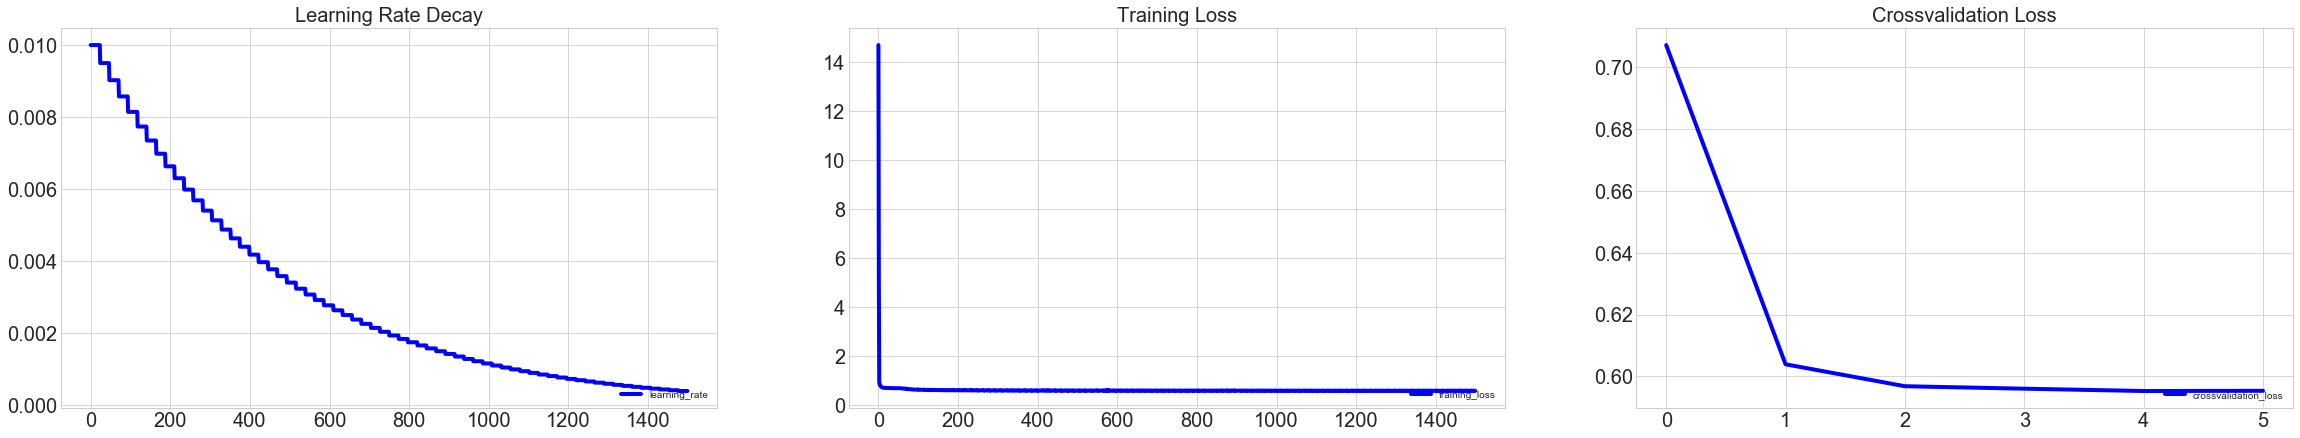

In [3]:
oj = Plot(rows=1, columns=3, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})

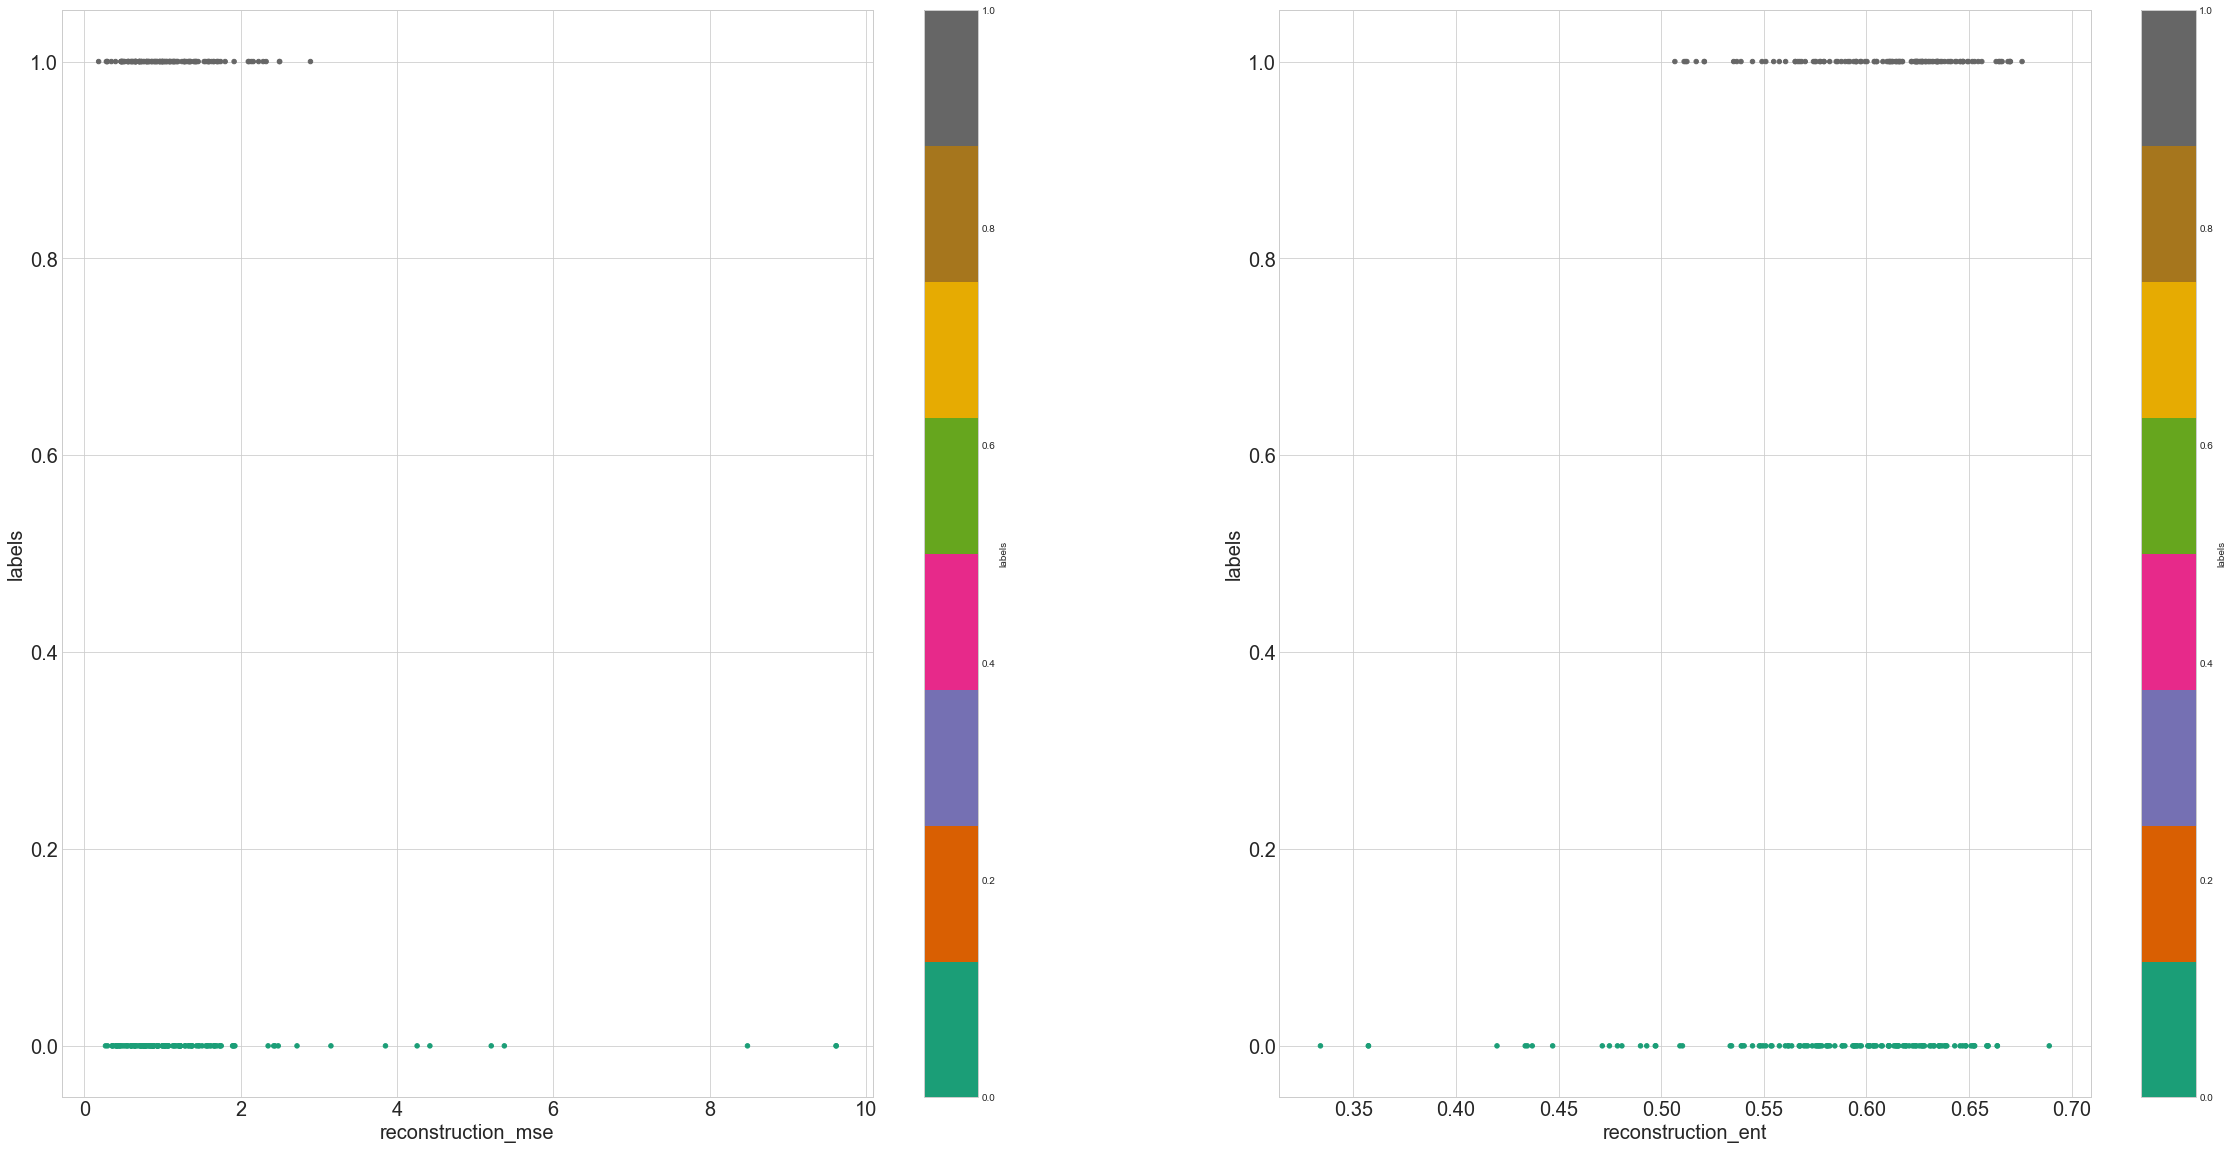

In [4]:
obj_plt = Plot(1,2,(40,20))
obj_plt.vizualize(reconsMSE_DF, colX='reconstruction_mse', colY='labels', label_col='labels', viz_type='scatter')
obj_plt.vizualize(reconsENT_DF, colX='reconstruction_ent', colY='labels', label_col='labels', viz_type='scatter')
# reconsMSE_DF.plot.scatter(x='labels', y='reconstruction_mse', c='labels', colormap='Dark2', ax=axs)

## Clustering with K-means on Autoencoder encodings:

input_image_shape = [64x64x3]
encoder downsampling = every layer decrease half, enc_filter = [3, 8, 16, 32, 64, 32, 16]
decoder upsampling = every layer increase twice, dec_filter = [16, 32, 64, 32, 16, 8, 3]


* We try a basic Convolutional autoencoder, and capture a 32 dimensional encoding (Encoder output). The Encoder output comes from Max pool, so we standarize the encodings, For 50 Epoch we see that the cluster formation when compared to the actual labels have a 70% of accuracy (The clusters were formed on Cross Validation Dataset and the clustering parameters were not tuned). Also, the cluster center for many dimension was zero, which could possibly mean that 32 dimensions could be redundant. 

* Next we try creating 16 dimension encoding. We now squash the encoder output through a tanh function to bound it by [-1,1]. A repeat the same experiment. The performance was even poor. Many encoding dimensions had recordings as 0 or 1 (The neurons were either activated or not). Which made the model baised. This could be because of the deeper architecture. 99% of the data points belonged to one cluster. So the accuracy was 50%. So we need to implement Batch noralization in the encoder layer. After using batch normalization, we had some sucess, atleast the actiovations were not always 0 and 1. Still almost all activations were at the higher end, 1.e grater than 0.6. Experimenting with batch normalization in the decoder unit too doesn't help. We see that squashing the encoder with tanh function itdetoriating the output, so we finally remove it. Removing it again brings and running the system for 100 iteration again brings out accuracy to 73%. Now we run teh stuff for total 300 iteration and the accuracy doesn't increase a lot.

* We remove squashing the autoencoder

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/assessor_code_images/checkpoint/autoencoder
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/assessor_code_images/summary/autoencoder
(?, 2, 2, 16)
Learning Rate: Initial:  0.01
(?, 16)
Checkpoint latest at:  /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/assessor_code_images/checkpoint/autoencoder/autoencoder_epoch_199_batch_14
cvalid_shape:  (250, 224, 400, 3)


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


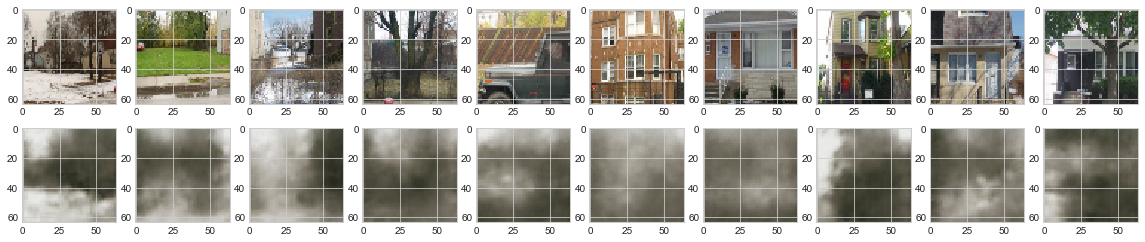

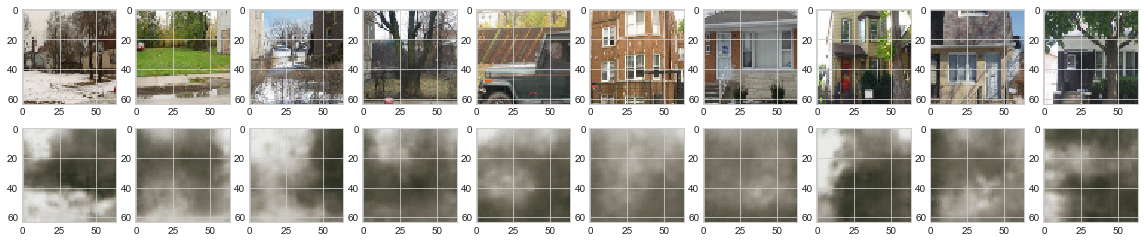

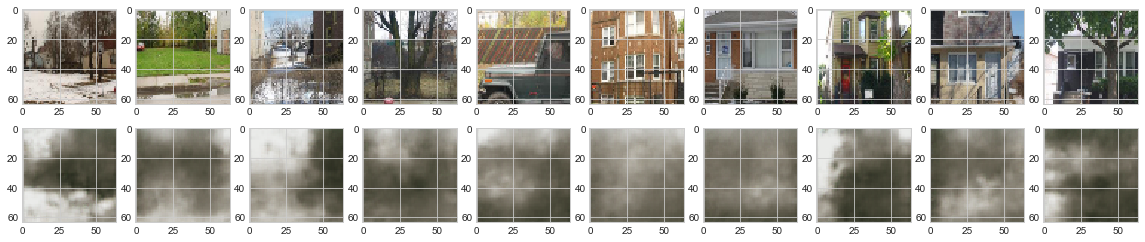

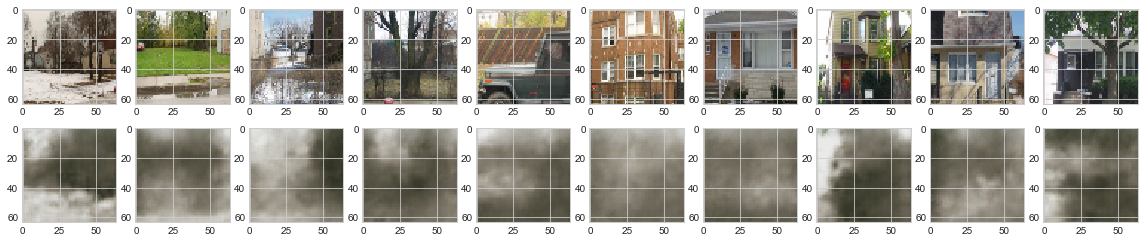

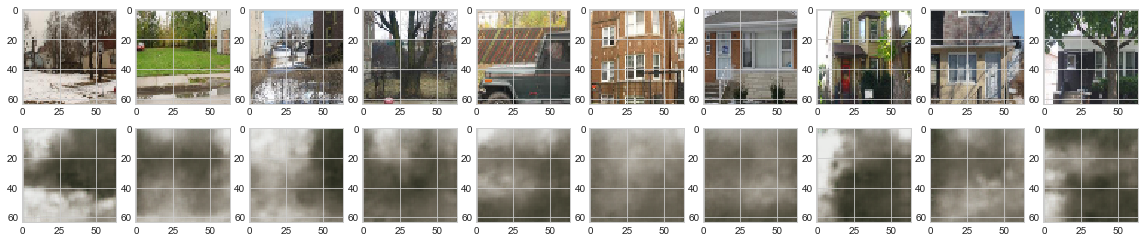

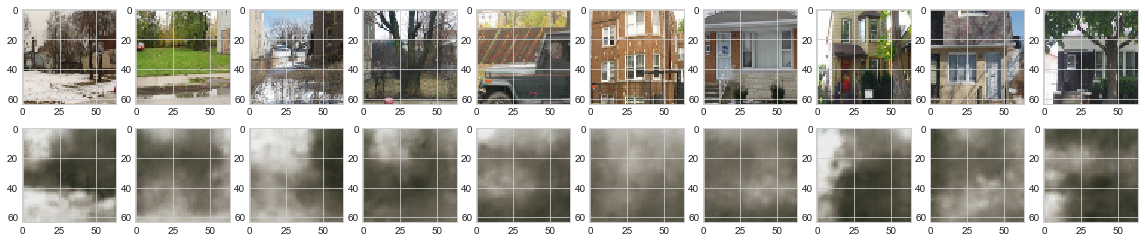

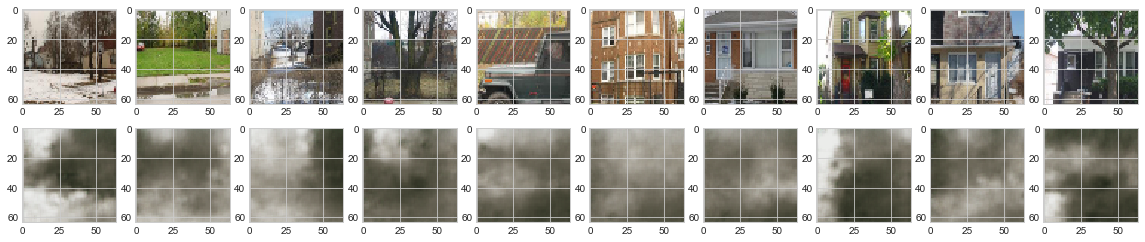

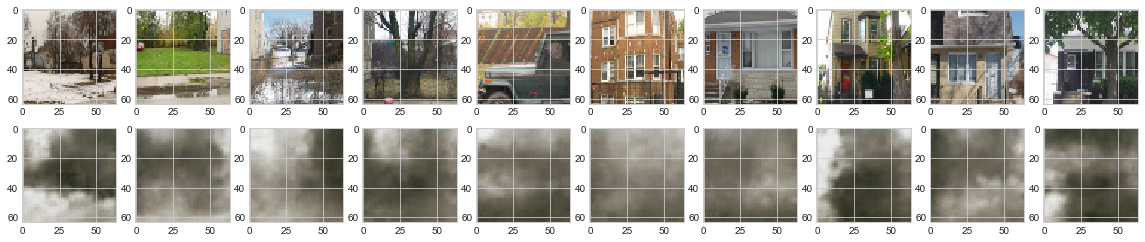

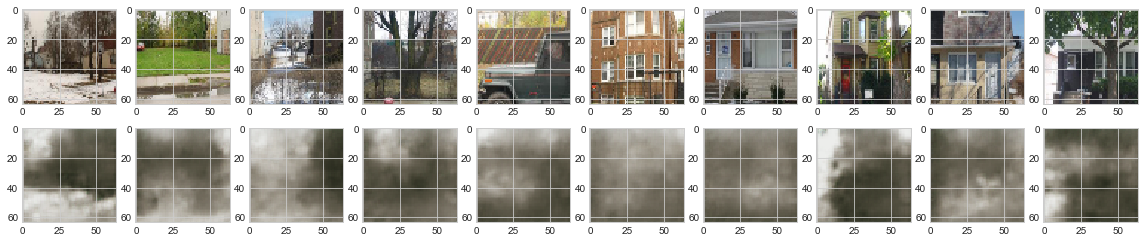

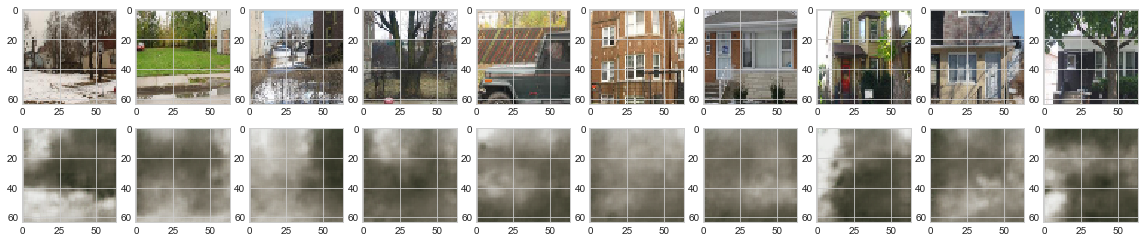

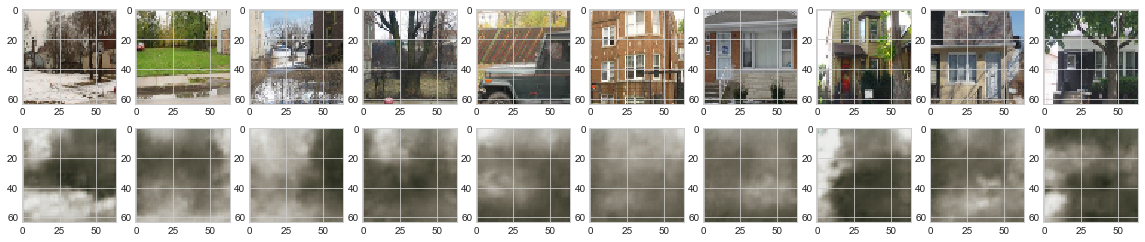

[[  0.          42.11152267  45.41970062 ...,  12.86987686  69.07295227
    0.        ]
 [  0.          12.39712334  25.88469315 ...,   7.04503679  13.75733566
    0.        ]
 [  0.          24.19895744  14.31872272 ...,  33.6874733   48.38876724
    0.        ]
 ..., 
 [  0.          69.25800323  18.51330948 ...,  35.01581192  42.14107513
    0.        ]
 [  0.          29.59126472  17.88415527 ...,  36.25805664  53.83763885
    0.        ]
 [  0.          18.32206345  33.23498535 ...,   0.          44.58106995
    0.        ]]


In [21]:
max_batches = 14

if train:
    tr_obj = TrainConvEnc(dict(learning_rate=0.01,
                            inp_img_shape=[224, 400, 3],
                            crop_shape=[128, 128, 3],
                            out_img_shape=[64, 64, 3],
                            use_checkpoint=True,
                            save_checkpoint=True,
                            write_tensorboard_summary=False
                            ),
                       device_type='gpu',
                       which_net='autoencoder',  # vgg
                       image_type='assessor_code')
    (tr_loss_arr, cv_loss_arr, l_rate_arr, cv_reconstruction_mse,
     cv_reconstruction_entropy, cvY_label, cv_encodings) = tr_obj.run(num_epochs=100, num_batches=max_batches+1, get_stats_at=10,
                                                        plot=True)  # + 1)
    print (cv_encodings)
    reconsMSE_DF = pd.DataFrame({'labels':cvY_label, 'reconstruction_mse': cv_reconstruction_mse})
    reconsENT_DF = pd.DataFrame({'labels':cvY_label, 'reconstruction_ent': cv_reconstruction_entropy})

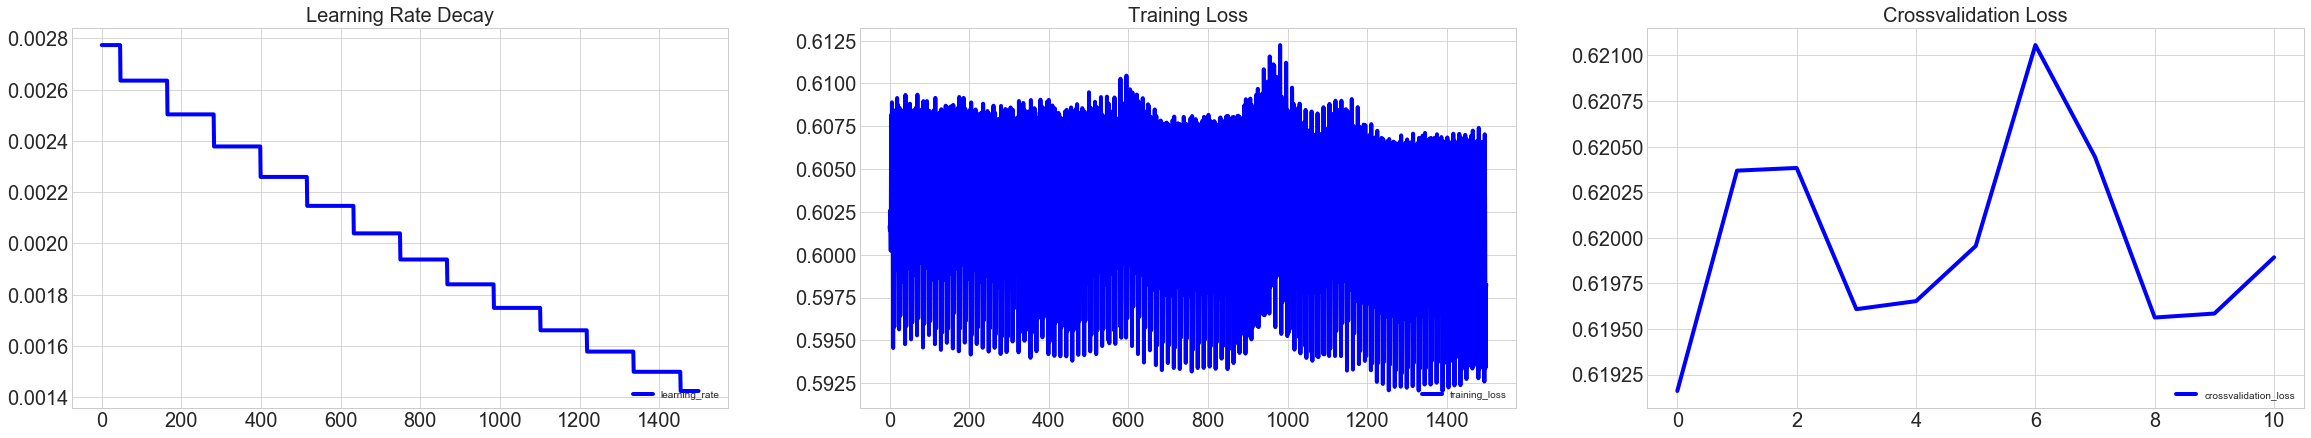

In [24]:
oj = Plot(rows=1, columns=3, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})

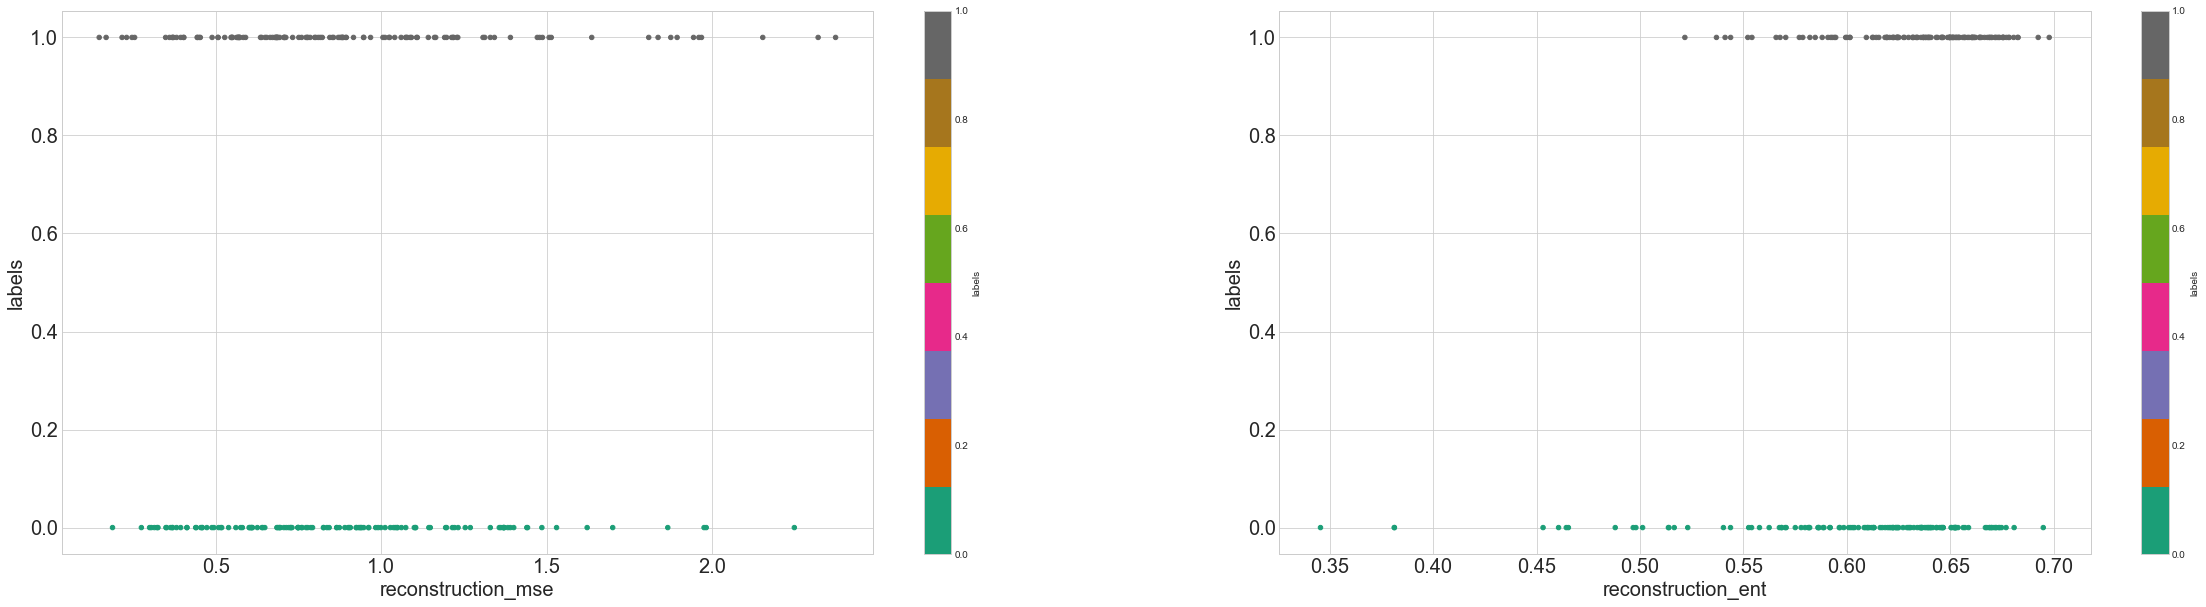

In [25]:
obj_plt = Plot(1,2,(40,10))
obj_plt.vizualize(reconsMSE_DF, colX='reconstruction_mse', colY='labels', label_col='labels', viz_type='scatter')
obj_plt.vizualize(reconsENT_DF, colX='reconstruction_ent', colY='labels', label_col='labels', viz_type='scatter')
# reconsMSE_DF.plot.scatter(x='labels', y='reconstruction_mse', c='labels', colormap='Dark2', ax=axs)

### CLUSTERING WITH K-MEANS

In [26]:
print (np.max(cv_encodings, axis=0))
print (np.min(cv_encodings, axis=0))

[   2.21302772  113.78146362  124.06403351  104.64248657  103.70463562
  134.47784424   26.4628067    77.28049469    0.92722094   85.02389526
  187.16697693  103.69779968  107.47296906   85.65251923  137.26239014
    8.9824295 ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit(cv_encodings)
labels = kmeans.predict(cv_encodings)
centroids = kmeans.cluster_centers_

In [28]:
centroids

array([[ -8.38190317e-09,   4.45971756e+01,   4.25235863e+01,
          5.17164879e+01,   4.28796120e+01,   5.09579659e+01,
          3.18295884e+00,   3.81449509e+01,   2.56113708e-09,
          3.15815411e+01,   7.45202484e+01,   3.98089943e+01,
          5.80318604e+01,   3.64767838e+01,   5.43488121e+01,
          1.08221993e-01],
       [  1.32516529e-02,   2.66884079e+01,   2.52244911e+01,
          2.93411179e+01,   2.24762230e+01,   2.38500252e+01,
          2.17204595e+00,   2.12274971e+01,   5.55222947e-03,
          1.84462566e+01,   3.81006088e+01,   2.62357693e+01,
          3.01447487e+01,   2.03314266e+01,   3.13502083e+01,
          8.54514763e-02]], dtype=float32)

In [29]:
labels

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

In [30]:
cvY_label

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [31]:
from conv_net.utils import Score
Score.accuracy(cvY_label, labels)

0.40799999999999997

# ROUGH:
---------------

In [3]:
house_pins = ['20-30-208-031-0000.jpg', '20-35-115-022-1009.jpg', '21-30-103-003-1018.jpg', '21-32-209-045-0000.jpg', '20-30-104-004-0000.jpg', '20-29-201-004-0000.jpg', '20-25-404-018-0000.jpg', '20-29-202-034-0000.jpg', '13-14-115-021-0000.jpg', '20-28-214-015-0000.jpg', '20-28-310-007-0000.jpg', '11-31-302-087-1004.jpg', '20-32-420-022-0000.jpg', '13-03-214-016-0000.jpg', '20-27-223-020-0000.jpg', '20-35-300-034-0000.jpg', '21-30-322-024-0000.jpg', '20-27-113-013-0000.jpg', '21-31-307-029-0000.jpg', '20-26-312-050-0000.jpg', '20-28-101-005-0000.jpg', '10-36-419-033-0000.jpg', '20-27-320-033-0000.jpg', '20-27-413-015-0000.jpg', '20-30-205-003-0000.jpg', '10-32-102-063-0000.jpg', '11-31-401-027-0000.jpg', '20-27-409-001-0000.jpg', '11-32-115-026-1001.jpg', '21-31-202-012-0000.jpg', '21-32-202-017-0000.jpg', '20-33-110-017-0000.jpg', '20-25-427-013-0000.jpg', '20-29-122-020-0000.jpg', '20-32-411-016-0000.jpg', '20-35-204-019-0000.jpg', '20-33-219-005-0000.jpg', '13-10-314-050-0000.jpg', '13-08-415-022-0000.jpg', '13-09-109-036-0000.jpg', '20-33-220-052-0000.jpg', '20-28-114-004-0000.jpg', '20-28-324-015-0000.jpg', '17-28-310-041-0000.jpg', '21-32-204-001-0000.jpg', '20-26-320-023-0000.jpg', '20-36-313-050-0000.jpg', '21-31-225-017-0000.jpg', '21-31-321-004-0000.jpg', '20-35-229-011-0000.jpg', '20-28-201-014-0000.jpg', '20-26-425-030-0000.jpg', '21-30-329-001-0000.jpg', '20-36-103-033-0000.jpg', '13-12-230-053-0000.jpg', '13-01-112-004-0000.jpg', '21-32-204-048-0000.jpg', '20-29-406-012-0000.jpg', '20-26-229-002-0000.jpg', '21-31-328-007-0000.jpg', '20-29-225-030-0000.jpg', '20-30-214-032-0000.jpg', '20-28-107-012-0000.jpg', '21-31-106-032-0000.jpg', '21-31-123-011-0000.jpg', '20-34-210-021-0000.jpg', '20-29-108-017-0000.jpg', '20-32-411-029-0000.jpg', '21-32-201-018-0000.jpg', '20-36-113-015-0000.jpg', '20-26-413-004-0000.jpg', '13-08-402-005-0000.jpg', '21-30-327-003-0000.jpg', '20-27-200-020-0000.jpg', '11-29-318-014-1049.jpg', '20-27-418-005-0000.jpg', '21-32-101-002-0000.jpg', '13-14-404-023-0000.jpg', '13-05-406-002-0000.jpg', '20-35-201-035-0000.jpg', '10-36-119-003-1006.jpg', '20-29-222-004-0000.jpg', '20-36-421-022-0000.jpg', '20-29-211-028-0000.jpg', '21-30-407-007-0000.jpg', '20-29-211-029-0000.jpg', '20-28-104-017-0000.jpg', '20-27-303-032-0000.jpg', '20-27-428-018-0000.jpg', '21-31-123-024-0000.jpg', '13-17-403-027-0000.jpg', '20-29-212-019-0000.jpg', '20-27-424-003-0000.jpg', '13-01-319-027-0000.jpg', '21-31-412-016-0000.jpg', '20-28-115-018-0000.jpg', '20-27-108-025-0000.jpg', '20-26-412-019-0000.jpg', '20-28-201-021-0000.jpg', '20-28-419-005-0000.jpg', '20-27-404-038-0000.jpg', '11-31-111-026-1014.jpg', '10-36-120-003-1093.jpg', '20-26-205-017-0000.jpg', '20-36-111-039-0000.jpg', '21-31-110-040-0000.jpg', '20-34-221-020-0000.jpg', '20-33-200-015-0000.jpg', '20-26-401-047-0000.jpg', '13-02-101-037-1001.jpg', '20-28-223-003-0000.jpg', '20-27-403-039-0000.jpg', '20-29-212-051-0000.jpg', '20-26-113-036-0000.jpg', '10-36-411-013-0000.jpg', '20-26-101-009-0000.jpg', '20-26-213-019-0000.jpg', '20-25-419-007-0000.jpg', '20-25-421-030-0000.jpg', '13-05-431-020-0000.jpg', '20-28-414-009-0000.jpg', '20-29-208-033-0000.jpg', '21-31-305-004-0000.jpg', '20-25-312-029-0000.jpg', '20-35-124-007-0000.jpg', '20-29-413-026-0000.jpg', '20-27-417-011-0000.jpg', '20-26-219-015-0000.jpg', '13-14-124-021-0000.jpg', '13-16-113-017-0000.jpg', '13-16-210-009-0000.jpg', '20-28-221-025-0000.jpg', '20-29-321-029-0000.jpg', '20-29-229-020-0000.jpg', '21-31-223-034-0000.jpg', '11-31-313-038-1002.jpg', '20-33-205-032-0000.jpg', '20-29-409-033-0000.jpg', '11-31-123-020-1085.jpg', '20-28-314-002-0000.jpg', '20-28-124-013-0000.jpg', '20-28-228-027-0000.jpg', '20-35-201-043-0000.jpg', '20-27-224-015-0000.jpg', '20-27-201-037-0000.jpg', '21-31-417-031-0000.jpg', '20-32-303-016-0000.jpg', '20-33-226-038-0000.jpg', '20-28-412-020-0000.jpg', '20-36-222-005-0000.jpg', '21-31-104-021-0000.jpg', '11-31-408-018-1004.jpg', '20-36-401-026-0000.jpg', '20-29-202-001-0000.jpg', '21-31-422-016-0000.jpg', '11-30-408-076-1050.jpg', '20-26-402-022-0000.jpg', '13-15-412-027-1018.jpg', '20-29-215-005-0000.jpg', '21-31-314-028-0000.jpg', '21-31-304-047-0000.jpg', '13-05-313-077-1001.jpg', '21-31-419-011-0000.jpg', '21-31-305-026-0000.jpg', '21-31-419-010-0000.jpg', '13-16-113-034-0000.jpg', '21-30-414-045-0000.jpg', '20-34-415-039-0000.jpg', '20-30-223-007-0000.jpg', '20-34-101-029-0000.jpg', '20-26-202-043-0000.jpg', '13-01-125-031-0000.jpg', '21-31-310-019-0000.jpg', '13-07-406-035-0000.jpg', '20-28-303-007-0000.jpg', '21-30-415-025-0000.jpg', '20-27-407-015-0000.jpg', '20-30-212-032-0000.jpg', '20-32-221-034-0000.jpg', '21-31-100-032-0000.jpg', '20-26-310-017-0000.jpg', '21-31-409-037-0000.jpg', '13-01-115-032-1016.jpg', '20-36-315-018-0000.jpg', '20-26-425-019-0000.jpg', '21-31-417-013-0000.jpg', '13-16-211-002-0000.jpg', '20-28-106-012-0000.jpg', '11-32-316-036-1022.jpg', '20-30-106-042-0000.jpg', '20-25-317-012-0000.jpg', '20-28-109-038-0000.jpg', '20-30-310-040-0000.jpg', '20-30-306-038-0000.jpg', '20-27-422-041-0000.jpg', '20-30-212-044-0000.jpg', '20-33-101-031-0000.jpg', '20-29-204-035-0000.jpg', '20-30-212-045-0000.jpg', '21-31-102-015-0000.jpg', '20-36-202-023-0000.jpg', '11-32-101-103-1019.jpg', '11-32-303-025-1012.jpg', '20-36-110-033-0000.jpg', '20-34-119-052-0000.jpg', '20-25-410-026-0000.jpg', '20-26-208-007-0000.jpg', '20-26-205-032-1019.jpg', '20-26-229-015-0000.jpg', '20-30-217-014-0000.jpg', '21-31-310-026-0000.jpg', '20-32-404-001-0000.jpg', '13-15-106-039-1010.jpg', '20-32-230-004-0000.jpg', '20-30-112-023-0000.jpg', '20-29-123-021-0000.jpg', '13-14-406-019-0000.jpg', '21-31-321-013-0000.jpg', '20-29-119-047-0000.jpg', '20-29-218-009-0000.jpg', '20-25-223-022-0000.jpg', '21-31-409-008-0000.jpg', '20-32-417-016-0000.jpg', '21-30-317-041-0000.jpg', '21-31-303-030-0000.jpg', '20-30-219-016-0000.jpg', '21-31-115-032-0000.jpg', '20-28-400-003-0000.jpg', '13-14-410-017-0000.jpg', '20-34-307-032-0000.jpg', '20-28-324-003-0000.jpg', '20-26-219-048-1004.jpg', '10-25-307-027-0000.jpg', '13-08-331-001-0000.jpg', '20-28-117-016-0000.jpg', '21-31-410-019-0000.jpg', '20-35-208-021-0000.jpg', '20-28-301-015-0000.jpg', '13-10-409-025-0000.jpg', '21-31-221-004-0000.jpg', '20-34-121-019-0000.jpg', '20-35-307-029-0000.jpg', '21-31-304-004-0000.jpg', '20-32-410-023-0000.jpg', '21-31-212-028-0000.jpg', '20-25-218-011-0000.jpg', '20-25-425-017-0000.jpg', '20-29-114-008-0000.jpg', '21-31-406-017-0000.jpg', '20-28-101-018-0000.jpg', '20-29-120-024-0000.jpg', '21-31-330-029-0000.jpg', '20-36-103-010-0000.jpg', '20-36-212-031-0000.jpg', '20-29-209-032-0000.jpg', '21-31-312-043-0000.jpg', '11-32-310-038-1007.jpg', '20-34-102-013-0000.jpg', '20-30-104-050-0000.jpg', '20-29-225-013-0000.jpg', '20-30-214-010-0000.jpg', '20-28-122-012-0000.jpg', '20-27-107-018-0000.jpg', '13-10-323-027-0000.jpg', '20-25-212-022-0000.jpg', '20-26-200-019-0000.jpg', '21-31-213-001-0000.jpg', '20-33-309-022-0000.jpg', '20-33-309-023-0000.jpg', '11-29-103-023-1002.jpg', '20-29-222-012-0000.jpg', '20-29-114-041-0000.jpg', '20-25-311-031-0000.jpg', '13-01-326-007-0000.jpg', '20-33-104-022-0000.jpg', '20-34-414-024-0000.jpg', '21-31-118-043-0000.jpg', '20-30-217-056-0000.jpg', '20-29-210-029-0000.jpg', '11-30-320-033-0000.jpg', '20-25-422-028-0000.jpg', '20-29-210-028-0000.jpg', '20-34-400-073-1004.jpg', '20-25-422-029-0000.jpg', '13-14-108-017-0000.jpg', '20-26-124-002-0000.jpg', '21-31-215-016-0000.jpg', '20-27-223-003-0000.jpg', '20-29-426-035-0000.jpg', '20-29-223-004-0000.jpg', '20-27-421-033-0000.jpg', '20-33-100-012-0000.jpg', '20-29-114-036-0000.jpg', '20-34-208-030-0000.jpg', '20-29-412-019-0000.jpg', '13-02-212-032-0000.jpg', '20-35-214-023-0000.jpg', '20-28-108-024-0000.jpg', '13-12-205-054-1002.jpg', '20-33-403-024-0000.jpg', '20-29-103-010-0000.jpg', '13-14-214-004-0000.jpg', '20-32-305-029-0000.jpg', '20-29-409-025-0000.jpg', '11-32-400-037-1002.jpg', '20-36-217-017-0000.jpg', '20-36-217-016-0000.jpg', '20-34-220-020-0000.jpg', '13-19-106-017-0000.jpg', '13-14-321-014-1005.jpg', '20-28-226-032-0000.jpg', '20-30-305-002-0000.jpg', '20-26-424-005-0000.jpg', '20-33-227-007-0000.jpg', '20-28-319-027-0000.jpg', '11-30-315-004-0000.jpg', '20-28-108-016-0000.jpg', '20-29-417-032-0000.jpg', '11-29-318-015-1029.jpg', '20-33-108-043-0000.jpg', '21-31-205-002-0000.jpg', '20-26-226-007-0000.jpg', '21-31-223-011-0000.jpg', '20-36-301-009-0000.jpg', '20-29-211-033-0000.jpg', '20-27-423-018-0000.jpg', '20-26-121-028-0000.jpg', '11-30-316-020-1015.jpg', '20-27-226-029-0000.jpg', '13-17-415-032-0000.jpg', '20-28-420-001-0000.jpg', '20-29-201-015-0000.jpg', '20-29-305-007-0000.jpg', '13-14-428-018-0000.jpg', '13-09-109-019-0000.jpg', '20-28-301-018-0000.jpg', '21-31-300-038-0000.jpg', '20-34-405-018-0000.jpg', '20-30-221-019-0000.jpg', '20-33-101-041-0000.jpg', '11-31-317-032-0000.jpg', '20-30-101-044-0000.jpg', '20-35-226-015-0000.jpg', '20-33-123-014-0000.jpg', '20-35-113-109-0000.jpg', '10-25-308-043-0000.jpg', '20-35-206-010-0000.jpg', '20-35-104-039-1002.jpg', '20-29-129-014-0000.jpg', '20-30-216-072-0000.jpg', '20-27-219-021-0000.jpg', '20-26-105-041-1001.jpg', '20-30-101-033-0000.jpg', '13-05-418-003-0000.jpg', '20-33-210-016-0000.jpg', '20-27-420-017-0000.jpg', '11-32-312-019-1010.jpg', '20-34-105-021-0000.jpg', '21-31-127-031-0000.jpg', '21-31-102-013-0000.jpg', '20-26-312-037-0000.jpg', '20-28-308-024-0000.jpg', '13-13-131-023-0000.jpg', '13-16-128-036-1006.jpg', '20-30-102-003-0000.jpg', '20-29-210-025-0000.jpg', '20-30-221-027-0000.jpg', '21-30-417-052-1016.jpg', '11-31-220-033-0000.jpg', '21-31-230-039-0000.jpg', '20-29-422-009-0000.jpg', '20-28-400-004-0000.jpg', '20-34-413-053-1033.jpg', '13-17-303-009-0000.jpg', '13-15-417-032-1026.jpg', '20-29-213-015-0000.jpg', '11-30-322-038-1016.jpg', '20-25-327-037-0000.jpg', '20-35-115-023-1043.jpg', '21-30-106-044-0000.jpg', '20-26-223-021-0000.jpg', '20-29-223-008-0000.jpg', '20-26-403-032-0000.jpg', '20-33-200-030-0000.jpg', '20-34-208-043-1011.jpg', '20-26-220-025-0000.jpg', '20-27-201-019-0000.jpg', '11-30-307-217-1004.jpg', '20-29-217-011-0000.jpg', '21-30-321-032-1006.jpg', '20-28-113-021-0000.jpg', '13-15-131-029-1011.jpg', '20-28-227-023-0000.jpg', '20-35-103-012-0000.jpg', '13-01-429-020-0000.jpg', '20-27-120-025-0000.jpg', '11-29-102-052-1004.jpg', '20-28-301-013-0000.jpg', '13-03-109-037-0000.jpg', '20-26-201-036-0000.jpg', '20-27-200-030-0000.jpg', '20-27-225-013-0000.jpg', '13-14-419-027-0000.jpg', '20-36-318-027-0000.jpg', '21-32-101-012-0000.jpg', '20-36-101-058-1002.jpg', '20-27-116-010-0000.jpg', '20-29-211-039-0000.jpg', '21-31-412-006-0000.jpg', '13-12-304-044-1006.jpg', '13-04-103-023-0000.jpg', '20-26-103-001-0000.jpg', '20-32-407-003-0000.jpg', '13-17-418-034-0000.jpg', '20-29-223-003-0000.jpg', '20-28-124-003-0000.jpg', '20-29-220-033-0000.jpg', '20-27-400-026-0000.jpg', '20-25-207-050-1006.jpg', '20-29-110-001-0000.jpg', '10-36-118-005-1210.jpg', '11-30-408-079-1002.jpg', '21-30-327-018-0000.jpg', '13-15-101-035-1004.jpg', '20-34-120-008-0000.jpg', '21-31-320-037-0000.jpg', '20-26-204-011-0000.jpg', '21-31-201-007-0000.jpg', '13-17-209-012-0000.jpg', '21-31-114-017-0000.jpg', '20-26-200-020-0000.jpg', '20-27-107-020-0000.jpg', '13-09-130-033-0000.jpg', '20-28-116-006-0000.jpg', '20-29-112-019-0000.jpg', '13-13-416-014-0000.jpg', '20-30-205-026-0000.jpg', '20-35-217-015-0000.jpg', '21-31-211-002-0000.jpg', '13-15-413-026-0000.jpg', '13-09-314-017-0000.jpg', '20-29-219-046-0000.jpg', '20-29-223-020-0000.jpg', '13-10-402-025-0000.jpg', '20-33-110-059-0000.jpg', '20-27-404-034-0000.jpg', '20-30-100-032-0000.jpg', '21-31-418-029-0000.jpg', '21-31-212-033-0000.jpg', '21-31-310-040-0000.jpg', '20-36-207-015-0000.jpg', '21-30-323-042-0000.jpg', '20-28-123-021-0000.jpg', '20-26-416-025-0000.jpg', '20-28-106-002-0000.jpg', '20-29-419-027-0000.jpg', '20-26-416-024-0000.jpg', '20-33-121-024-0000.jpg', '20-33-312-005-0000.jpg', '20-29-113-013-0000.jpg', '11-31-122-032-1016.jpg', '20-29-227-011-0000.jpg', '20-26-101-004-0000.jpg', '20-27-211-022-0000.jpg', '21-32-202-011-0000.jpg', '13-13-310-042-1002.jpg', '20-29-410-024-0000.jpg', '20-27-229-014-0000.jpg', '20-29-217-044-0000.jpg', '20-34-218-033-0000.jpg', '20-33-306-013-0000.jpg', '13-08-402-042-1011.jpg', '20-35-113-028-0000.jpg', '20-36-331-002-0000.jpg', '20-26-115-013-0000.jpg', '21-31-201-024-0000.jpg', '20-35-408-013-0000.jpg', '20-27-216-022-0000.jpg', '21-32-207-041-0000.jpg', '13-19-126-040-0000.jpg', '20-33-206-030-0000.jpg', '20-30-205-004-0000.jpg', '20-25-423-024-0000.jpg', '20-33-301-012-0000.jpg', '20-34-404-026-0000.jpg', '20-29-211-024-0000.jpg', '20-34-213-028-0000.jpg', '20-34-224-034-0000.jpg', '20-27-428-015-0000.jpg', '13-13-410-020-0000.jpg', '20-36-308-022-0000.jpg', '20-29-217-032-0000.jpg', '20-33-112-036-0000.jpg', '20-36-308-023-0000.jpg', '21-31-423-011-0000.jpg', '20-32-413-037-0000.jpg', '20-29-411-033-0000.jpg', '21-31-112-023-0000.jpg', '20-27-231-026-0000.jpg', '13-01-225-040-1030.jpg', '13-17-108-008-0000.jpg', '13-01-225-040-1024.jpg', '13-16-200-022-0000.jpg', '20-32-317-044-0000.jpg', '13-12-211-041-1019.jpg', '20-28-301-030-0000.jpg', '13-05-114-008-0000.jpg', '20-35-311-002-0000.jpg', '13-13-117-027-0000.jpg', '20-27-418-036-0000.jpg', '21-30-417-052-1010.jpg', '20-35-124-191-0000.jpg', '20-28-100-015-0000.jpg', '13-13-113-036-1003.jpg', '20-29-402-024-0000.jpg', '13-12-301-033-1018.jpg', '20-33-106-021-0000.jpg', '20-36-305-083-0000.jpg', '20-27-403-043-0000.jpg', '20-29-126-029-0000.jpg', '20-28-107-015-0000.jpg', '13-05-115-020-0000.jpg', '10-36-216-008-0000.jpg', '13-15-124-003-0000.jpg', '20-33-118-005-0000.jpg', '20-29-319-012-0000.jpg', '20-27-402-016-0000.jpg', '20-29-201-041-0000.jpg', '20-29-201-040-0000.jpg', '21-31-310-002-0000.jpg', '21-31-217-020-0000.jpg', '13-15-228-002-0000.jpg', '13-15-415-005-0000.jpg', '13-08-129-010-0000.jpg', '13-07-103-030-0000.jpg', '21-30-109-004-0000.jpg', '20-34-413-053-1037.jpg', '20-35-113-023-0000.jpg', '20-36-404-007-0000.jpg', '20-33-102-025-0000.jpg', '20-34-109-019-0000.jpg', '20-32-316-011-0000.jpg', '20-29-202-038-0000.jpg', '13-15-318-074-0000.jpg', '20-29-317-025-0000.jpg', '10-36-118-005-1217.jpg', '20-33-110-053-0000.jpg', '20-28-419-003-0000.jpg', '20-28-224-004-0000.jpg', '20-26-218-005-0000.jpg', '20-29-114-018-0000.jpg', '20-30-203-027-0000.jpg', '21-32-200-002-0000.jpg', '21-30-114-027-1011.jpg', '13-03-320-015-0000.jpg', '13-13-303-008-0000.jpg', '21-32-200-003-0000.jpg', '20-34-302-047-0000.jpg', '21-30-104-036-0000.jpg', '11-30-401-033-1011.jpg', '21-31-322-006-0000.jpg', '20-29-411-006-0000.jpg', '21-31-224-044-0000.jpg', '20-35-124-077-0000.jpg', '20-26-401-041-0000.jpg', '21-30-414-061-0000.jpg', '10-25-306-014-0000.jpg', '13-13-124-001-0000.jpg', '20-36-117-028-0000.jpg', '21-32-205-024-0000.jpg', '20-33-218-021-0000.jpg', '13-03-324-053-0000.jpg', '21-31-204-040-0000.jpg', '13-15-317-029-0000.jpg', '20-35-104-039-1013.jpg', '20-35-218-028-0000.jpg', '20-34-218-006-0000.jpg', '20-25-208-018-0000.jpg', '20-32-313-036-0000.jpg', '13-01-225-040-1027.jpg', '20-28-226-022-0000.jpg', '20-25-303-021-0000.jpg', '21-31-202-021-0000.jpg', '13-08-121-004-0000.jpg', '21-30-101-031-1003.jpg', '21-31-201-010-0000.jpg', '20-25-426-040-0000.jpg', '21-31-128-007-0000.jpg', '20-26-219-012-0000.jpg', '20-26-401-037-0000.jpg', '20-30-202-031-0000.jpg', '20-29-201-036-0000.jpg', '20-30-215-017-0000.jpg', '20-29-201-037-0000.jpg', '20-33-121-010-0000.jpg', '21-31-105-046-0000.jpg', '20-33-109-049-0000.jpg', '11-31-122-032-1014.jpg', '21-30-417-052-1013.jpg', '20-33-109-048-0000.jpg', '20-25-314-007-0000.jpg', '20-33-219-009-0000.jpg', '20-25-411-014-0000.jpg', '20-29-206-036-0000.jpg', '13-16-312-035-0000.jpg', '20-28-124-014-0000.jpg', '11-30-315-020-1019.jpg', '20-29-114-027-0000.jpg', '20-28-332-017-0000.jpg', '21-30-321-032-1001.jpg', '20-29-213-025-0000.jpg', '13-05-106-010-0000.jpg', '20-35-410-006-0000.jpg', '20-32-416-040-0000.jpg', '13-09-407-080-0000.jpg', '20-36-107-022-0000.jpg', '21-30-330-004-0000.jpg', '20-26-321-029-1007.jpg', '20-36-219-028-0000.jpg', '20-35-113-078-0000.jpg', '20-32-413-010-0000.jpg', '21-32-200-011-0000.jpg', '20-27-213-022-0000.jpg', '13-03-135-035-0000.jpg', '11-31-122-032-1019.jpg', '20-29-220-009-0000.jpg', '21-30-404-022-0000.jpg', '20-27-424-017-0000.jpg', '20-28-108-018-0000.jpg', '20-30-108-048-0000.jpg', '20-35-205-011-0000.jpg', '20-27-311-019-0000.jpg', '21-32-206-038-0000.jpg', '20-33-205-019-0000.jpg', '21-31-408-017-0000.jpg', '21-31-419-018-0000.jpg', '20-27-227-047-0000.jpg', '13-07-231-041-0000.jpg', '21-31-416-032-0000.jpg', '20-33-312-023-0000.jpg', '20-25-407-009-0000.jpg', '20-32-420-002-0000.jpg', '20-32-405-020-0000.jpg', '20-35-302-044-0000.jpg', '20-27-114-032-0000.jpg', '20-35-104-029-0000.jpg', '20-30-208-010-0000.jpg', '10-32-419-031-0000.jpg', '21-31-411-044-0000.jpg', '20-29-127-018-0000.jpg', '20-29-114-034-0000.jpg', '20-27-419-006-0000.jpg', '13-12-314-033-1002.jpg', '20-35-100-019-0000.jpg', '20-27-408-009-0000.jpg', '13-08-223-021-0000.jpg', '20-26-105-012-0000.jpg', '20-29-223-006-0000.jpg', '13-07-214-014-0000.jpg', '21-31-424-040-0000.jpg', '13-13-128-009-0000.jpg', '10-36-410-010-0000.jpg', '11-31-122-032-1018.jpg', '21-30-331-012-0000.jpg', '20-36-310-036-0000.jpg', '20-29-126-030-0000.jpg', '20-33-105-008-0000.jpg', '20-29-214-052-0000.jpg', '21-30-106-002-0000.jpg', '21-31-201-003-0000.jpg', '20-29-413-032-0000.jpg', '13-11-320-005-0000.jpg', '21-31-113-012-0000.jpg', '11-30-307-102-0000.jpg', '20-35-124-188-0000.jpg', '20-30-203-043-0000.jpg', '11-29-320-051-1014.jpg', '20-29-413-006-0000.jpg', '21-31-404-007-0000.jpg', '20-30-210-029-0000.jpg', '20-29-216-037-0000.jpg', '13-16-324-026-0000.jpg', '20-28-211-019-0000.jpg', '20-26-402-021-0000.jpg', '20-25-427-007-0000.jpg', '13-07-402-006-0000.jpg', '20-30-214-018-0000.jpg', '20-29-212-006-0000.jpg', '20-34-306-026-0000.jpg', '21-31-301-015-0000.jpg', '13-01-103-021-0000.jpg', '21-31-212-021-0000.jpg', '11-31-116-052-1004.jpg', '20-29-205-020-0000.jpg', '20-29-220-002-0000.jpg', '11-31-122-025-1008.jpg', '13-08-402-042-1009.jpg', '13-01-206-016-0000.jpg', '21-31-211-011-0000.jpg', '21-31-315-002-0000.jpg', '20-27-210-018-0000.jpg', '20-28-209-015-0000.jpg', '10-29-304-006-0000.jpg', '20-25-408-016-0000.jpg', '20-26-415-007-0000.jpg', '20-29-202-021-0000.jpg', '11-30-317-018-0000.jpg', '20-29-224-032-0000.jpg', '20-30-215-030-0000.jpg', '20-29-320-020-0000.jpg', '20-29-404-020-0000.jpg', '20-29-404-021-0000.jpg', '20-27-301-034-0000.jpg', '20-27-226-012-0000.jpg', '10-32-215-009-0000.jpg', '20-29-410-009-0000.jpg', '13-13-324-015-0000.jpg', '20-29-108-003-0000.jpg', '21-31-311-045-0000.jpg', '20-25-212-014-0000.jpg', '21-31-217-006-0000.jpg', '10-36-204-024-0000.jpg', '20-26-319-028-0000.jpg', '10-36-205-060-1009.jpg', '20-29-111-026-0000.jpg', '20-30-310-035-0000.jpg', '10-36-204-025-0000.jpg', '20-29-211-008-0000.jpg', '21-30-407-027-0000.jpg', '13-14-324-032-0000.jpg', '20-32-224-011-0000.jpg', '21-30-323-027-0000.jpg', '21-31-231-014-0000.jpg', '21-31-322-020-0000.jpg', '21-32-201-045-0000.jpg', '20-26-403-036-0000.jpg', '21-31-406-020-0000.jpg', '21-30-412-050-0000.jpg', '20-26-219-042-0000.jpg', '20-30-200-031-0000.jpg', '20-27-430-034-0000.jpg', '20-26-425-024-0000.jpg', '20-28-110-020-0000.jpg', '13-02-218-009-0000.jpg', '20-27-404-019-0000.jpg', '20-28-305-013-0000.jpg', '20-26-206-051-1002.jpg', '13-13-331-042-1017.jpg', '20-29-119-044-0000.jpg', '13-08-311-045-0000.jpg', '20-34-222-031-0000.jpg', '20-28-109-004-0000.jpg', '20-35-230-020-0000.jpg', '20-27-205-018-0000.jpg', '21-31-204-010-0000.jpg', '20-36-119-033-0000.jpg', '11-30-408-076-1002.jpg', '13-16-225-012-0000.jpg', '21-31-400-040-0000.jpg', '20-30-221-023-0000.jpg', '21-32-207-024-0000.jpg', '20-27-226-031-0000.jpg', '21-31-103-054-0000.jpg', '20-26-311-021-0000.jpg', '20-27-226-030-0000.jpg', '20-30-102-024-0000.jpg', '10-36-112-026-0000.jpg', '20-25-410-007-0000.jpg', '20-33-102-021-0000.jpg', '21-30-400-004-0000.jpg', '20-30-101-014-0000.jpg', '20-35-420-045-0000.jpg', '20-28-316-026-0000.jpg', '20-27-200-023-0000.jpg', '21-31-217-024-0000.jpg', '10-36-100-018-1134.jpg', '13-13-306-015-0000.jpg', '13-09-411-043-0000.jpg', '20-30-223-018-0000.jpg', '20-36-403-003-0000.jpg', '20-34-309-011-0000.jpg', '11-31-122-032-1023.jpg', '13-07-308-023-0000.jpg', '13-09-428-015-0000.jpg', '13-08-112-012-0000.jpg', '20-28-119-001-0000.jpg', '20-25-327-010-0000.jpg', '20-26-223-006-0000.jpg', '20-33-225-035-0000.jpg', '21-30-410-022-0000.jpg', '20-30-202-042-0000.jpg', '20-33-110-057-0000.jpg', '13-14-414-007-0000.jpg', '21-31-418-026-0000.jpg', '20-36-311-036-0000.jpg', '13-08-308-043-0000.jpg', '20-35-104-039-1018.jpg', '11-31-105-019-0000.jpg', '20-34-406-030-0000.jpg', '20-35-119-015-0000.jpg', '21-31-222-021-0000.jpg', '20-25-227-032-0000.jpg', '20-29-424-039-0000.jpg', '20-29-424-038-0000.jpg', '21-31-317-038-0000.jpg', '20-29-413-025-0000.jpg', '20-27-103-002-0000.jpg', '20-36-210-002-0000.jpg', '20-29-214-045-0000.jpg', '11-29-320-010-0000.jpg', '20-25-426-045-0000.jpg', '20-29-104-004-0000.jpg', '20-26-402-002-0000.jpg', '20-34-217-029-0000.jpg', '20-25-137-005-0000.jpg', '20-34-110-007-0000.jpg', '20-36-217-002-0000.jpg', '13-16-110-024-0000.jpg', '21-31-218-030-0000.jpg', '20-27-107-033-0000.jpg', '20-27-317-019-0000.jpg', '10-36-406-040-0000.jpg', '20-32-410-009-0000.jpg', '20-34-230-012-0000.jpg', '20-27-404-005-0000.jpg', '13-17-200-002-0000.jpg', '21-30-326-023-0000.jpg', '20-36-321-015-0000.jpg', '20-29-209-018-0000.jpg', '20-35-418-004-0000.jpg', '20-28-228-025-0000.jpg', '21-31-211-033-0000.jpg', '21-31-217-053-0000.jpg', '21-31-215-003-0000.jpg', '20-34-124-062-0000.jpg', '20-30-105-052-0000.jpg', '21-31-410-032-0000.jpg', '13-13-407-040-0000.jpg', '20-35-219-004-0000.jpg', '20-28-214-022-0000.jpg', '20-29-305-021-0000.jpg', '20-27-205-004-0000.jpg', '20-28-109-019-0000.jpg', '20-25-317-033-0000.jpg', '13-17-219-012-0000.jpg', '20-29-422-025-0000.jpg', '20-28-209-003-0000.jpg', '20-25-224-008-0000.jpg', '20-28-400-029-0000.jpg', '20-35-124-170-0000.jpg', '20-26-102-030-0000.jpg', '20-29-128-010-0000.jpg', '21-31-115-019-0000.jpg', '20-35-313-022-1007.jpg', '20-29-201-007-0000.jpg', '20-30-317-054-0000.jpg', '13-17-107-110-0000.jpg', '20-28-110-008-0000.jpg', '20-29-114-016-0000.jpg', '20-36-320-041-0000.jpg', '20-36-321-020-0000.jpg', '11-31-122-032-1020.jpg', '21-31-409-023-0000.jpg', '21-30-410-029-0000.jpg', '20-28-202-018-0000.jpg', '13-15-411-038-1013.jpg', '20-30-212-027-0000.jpg', '20-27-230-034-0000.jpg', '20-35-124-139-0000.jpg', '20-29-414-010-0000.jpg', '20-30-109-034-0000.jpg', '13-02-210-042-0000.jpg', '20-36-105-027-0000.jpg', '20-34-407-013-0000.jpg', '20-36-118-032-0000.jpg', '13-09-212-019-0000.jpg', '20-27-200-029-0000.jpg', '13-01-116-009-0000.jpg', '20-34-303-060-0000.jpg', '21-31-227-032-0000.jpg', '13-13-232-010-0000.jpg', '20-29-104-030-0000.jpg', '20-26-218-042-0000.jpg', '20-29-213-006-0000.jpg', '21-31-219-013-0000.jpg', '20-33-222-001-0000.jpg', '20-34-307-027-0000.jpg', '20-26-305-002-0000.jpg', '20-26-210-048-1002.jpg', '13-17-402-038-0000.jpg', '20-33-108-026-0000.jpg', '13-09-328-060-1007.jpg', '21-31-427-025-0000.jpg', '20-36-411-040-0000.jpg', '20-30-221-034-0000.jpg', '20-30-200-027-0000.jpg', '13-06-210-016-0000.jpg', '13-10-312-033-0000.jpg', '13-12-226-016-0000.jpg', '21-31-200-037-0000.jpg', '20-26-220-002-0000.jpg', '20-28-213-029-0000.jpg', '20-28-107-010-0000.jpg', '20-35-209-028-0000.jpg', '13-06-221-022-0000.jpg', '13-15-101-024-0000.jpg', '20-26-417-036-0000.jpg', '20-28-107-011-0000.jpg', '20-35-302-011-0000.jpg', '20-36-301-025-0000.jpg', '21-31-231-003-0000.jpg', '20-28-104-021-0000.jpg', '20-25-213-029-1013.jpg', '20-35-218-026-0000.jpg', '20-29-222-033-0000.jpg', '20-29-207-010-0000.jpg', '20-35-124-195-0000.jpg', '21-31-210-010-0000.jpg', '20-26-321-029-1003.jpg', '13-05-431-029-0000.jpg', '20-27-203-027-0000.jpg', '13-13-114-013-0000.jpg', '20-25-312-020-0000.jpg', '13-02-415-059-1001.jpg', '21-31-213-020-0000.jpg', '20-27-405-026-0000.jpg', '20-27-417-019-0000.jpg', '20-27-424-007-0000.jpg', '21-32-209-002-0000.jpg', '10-36-303-023-0000.jpg', '20-28-311-020-0000.jpg', '20-28-334-002-0000.jpg', '20-32-320-026-0000.jpg', '20-29-201-043-0000.jpg', '21-30-323-003-0000.jpg', '20-32-412-028-0000.jpg', '21-31-331-012-0000.jpg', '20-34-121-042-0000.jpg', '20-28-211-002-0000.jpg', '21-32-204-030-0000.jpg', '11-31-123-020-1105.jpg', '21-30-417-024-0000.jpg', '20-28-301-006-0000.jpg', '20-26-318-025-0000.jpg', '20-28-220-037-0000.jpg', '21-30-414-015-0000.jpg', '13-01-115-032-1019.jpg', '21-30-101-032-1002.jpg', '21-31-230-018-0000.jpg', '21-30-100-005-0000.jpg', '21-31-112-015-0000.jpg', '10-32-105-024-0000.jpg', '20-29-118-001-0000.jpg', '21-30-410-024-0000.jpg', '20-26-401-042-0000.jpg', '20-29-123-007-0000.jpg', '21-31-321-034-0000.jpg', '20-36-301-028-0000.jpg', '21-32-206-016-0000.jpg', '20-29-213-042-0000.jpg', '11-31-216-019-0000.jpg', '20-30-114-012-0000.jpg', '13-08-432-017-0000.jpg', '20-28-221-020-0000.jpg', '20-34-202-010-0000.jpg', '20-26-418-011-0000.jpg', '13-14-411-026-0000.jpg', '21-32-205-027-0000.jpg', '21-31-201-012-0000.jpg', '21-30-101-032-1003.jpg', '20-26-205-032-1016.jpg', '20-27-316-037-0000.jpg', '21-31-224-030-0000.jpg', '20-36-309-002-0000.jpg', '20-29-104-003-0000.jpg', '20-29-311-031-0000.jpg', '11-32-114-031-1008.jpg', '11-31-123-020-1104.jpg', '20-34-114-030-0000.jpg', '20-36-102-014-0000.jpg', '20-30-318-004-0000.jpg', '20-34-200-009-0000.jpg', '13-19-113-072-0000.jpg', '13-02-432-030-1007.jpg', '20-28-105-004-0000.jpg', '21-31-208-010-0000.jpg', '20-32-304-013-0000.jpg', '20-27-209-018-0000.jpg', '20-29-306-017-0000.jpg', '20-27-427-040-0000.jpg', '20-27-419-017-0000.jpg', '20-25-217-016-0000.jpg', '20-28-332-015-0000.jpg', '21-31-417-035-0000.jpg', '20-26-109-019-0000.jpg', '20-35-115-022-1015.jpg', '20-30-316-007-0000.jpg', '20-29-223-017-0000.jpg', '20-35-200-026-0000.jpg', '20-25-429-020-0000.jpg', '21-31-315-026-0000.jpg', '20-28-228-017-0000.jpg', '20-26-214-016-0000.jpg', '20-34-216-033-0000.jpg', '20-27-113-016-0000.jpg', '20-28-228-016-0000.jpg', '11-30-312-027-1005.jpg', '11-31-114-022-1030.jpg', '13-03-214-012-0000.jpg', '20-25-331-012-0000.jpg', '11-31-302-083-1004.jpg', '20-35-124-177-0000.jpg', '20-32-406-034-0000.jpg', '13-12-235-050-1003.jpg', '20-25-213-013-0000.jpg', '20-29-224-023-0000.jpg', '20-29-203-050-0000.jpg', '21-32-209-040-0000.jpg', '20-29-122-025-0000.jpg', '11-32-330-019-0000.jpg', '20-35-228-002-0000.jpg', '21-31-128-031-0000.jpg', '13-07-108-023-0000.jpg', '11-30-322-042-1019.jpg', '20-26-303-013-0000.jpg', '20-27-211-021-0000.jpg', '21-31-202-016-0000.jpg', '21-31-103-058-0000.jpg', '10-31-208-036-0000.jpg', '20-29-116-009-0000.jpg', '21-31-407-027-0000.jpg', '11-32-101-068-0000.jpg', '10-36-213-006-1028.jpg', '20-30-201-037-0000.jpg', '20-36-412-001-0000.jpg', '20-35-113-123-0000.jpg', '20-25-226-017-0000.jpg', '21-30-323-008-0000.jpg', '20-26-304-013-0000.jpg', '20-36-411-030-0000.jpg', '21-31-109-022-0000.jpg', '20-30-200-021-0000.jpg', '13-10-312-034-0000.jpg', '21-31-113-040-0000.jpg', '21-31-200-031-0000.jpg', '20-29-217-030-0000.jpg', '20-30-203-011-0000.jpg', '20-34-400-073-1037.jpg', '20-36-229-011-0000.jpg', '20-26-109-012-0000.jpg', '20-33-110-065-0000.jpg', '20-27-207-013-1007.jpg', '20-28-400-010-0000.jpg', '21-31-115-020-0000.jpg', '13-13-126-011-0000.jpg', '20-36-312-034-0000.jpg', '11-31-123-020-1107.jpg', '13-15-306-066-0000.jpg', '20-29-101-011-0000.jpg', '20-29-222-034-0000.jpg', '20-25-410-035-0000.jpg', '20-29-222-035-0000.jpg', '20-27-229-028-0000.jpg', '13-07-410-016-0000.jpg', '13-04-209-056-0000.jpg', '21-31-102-006-0000.jpg', '20-29-108-012-0000.jpg', '20-29-219-032-0000.jpg', '20-26-122-032-0000.jpg', '20-28-316-014-0000.jpg', '13-14-408-009-0000.jpg', '20-26-413-001-0000.jpg', '20-35-302-085-0000.jpg', '20-30-113-018-0000.jpg', '21-31-402-048-0000.jpg', '11-29-107-034-1002.jpg', '11-29-319-018-1020.jpg', '20-35-403-034-0000.jpg', '20-25-136-068-0000.jpg', '21-30-323-036-0000.jpg', '20-28-104-026-0000.jpg', '20-28-104-027-0000.jpg', '20-28-311-015-0000.jpg', '20-29-429-025-0000.jpg', '20-26-426-026-0000.jpg', '13-19-105-054-0000.jpg', '21-31-112-002-0000.jpg', '13-10-312-017-0000.jpg', '20-36-211-005-0000.jpg', '20-25-207-051-0000.jpg', '21-32-200-017-0000.jpg', '13-16-218-047-0000.jpg', '20-28-318-035-0000.jpg', '20-36-315-016-0000.jpg', '20-33-112-017-0000.jpg', '20-29-217-013-0000.jpg', '11-30-307-215-1004.jpg', '20-33-112-016-0000.jpg', '20-30-222-020-0000.jpg', '13-06-110-052-1025.jpg', '20-29-127-020-0000.jpg', '20-30-208-028-0000.jpg', '20-25-224-013-0000.jpg', '20-28-218-016-0000.jpg', '20-28-109-036-0000.jpg', '20-26-224-016-0000.jpg', '20-26-202-004-0000.jpg', '20-25-228-009-0000.jpg', '11-31-123-020-1103.jpg', '21-31-415-004-0000.jpg', '13-03-100-036-0000.jpg', '11-30-424-032-0000.jpg', '20-25-311-034-0000.jpg', '20-29-427-027-0000.jpg', '21-30-101-032-1004.jpg', '20-34-107-047-0000.jpg', '13-12-213-061-1002.jpg', '13-02-413-008-0000.jpg', '20-25-417-016-0000.jpg', '20-29-200-034-0000.jpg', '21-30-404-025-0000.jpg', '20-32-227-012-0000.jpg', '20-33-209-005-0000.jpg', '20-30-209-001-0000.jpg', '21-31-105-025-0000.jpg', '11-31-208-030-1009.jpg', '21-31-214-004-0000.jpg', '20-36-324-023-0000.jpg', '20-30-104-054-0000.jpg', '13-12-411-079-1004.jpg', '20-26-425-028-0000.jpg', '20-29-119-049-0000.jpg', '20-34-400-073-1026.jpg', '20-26-302-019-0000.jpg', '20-29-132-021-0000.jpg', '20-33-212-007-0000.jpg', '20-30-107-012-0000.jpg', '20-27-426-036-0000.jpg', '21-31-217-043-0000.jpg', '20-27-207-013-1002.jpg', '20-29-407-023-0000.jpg', '20-27-206-024-0000.jpg', '20-27-205-014-0000.jpg', '20-27-220-037-0000.jpg', '10-36-400-030-0000.jpg', '20-35-222-012-0000.jpg', '21-31-411-043-0000.jpg', '20-33-121-004-0000.jpg', '20-29-305-031-0000.jpg', '13-13-118-012-0000.jpg', '11-31-123-020-1089.jpg', '11-29-106-023-1006.jpg', '13-02-432-030-1015.jpg', '21-31-201-004-0000.jpg', '20-26-221-031-0000.jpg', '20-35-124-014-0000.jpg', '20-35-202-029-0000.jpg', '20-34-220-024-0000.jpg', '20-29-208-021-0000.jpg', '21-31-407-005-0000.jpg', '20-27-414-033-0000.jpg', '20-34-109-032-0000.jpg', '20-36-414-042-0000.jpg', '20-27-308-004-0000.jpg', '20-30-110-034-0000.jpg', '21-30-417-044-0000.jpg', '21-31-426-017-0000.jpg', '20-34-404-007-0000.jpg', '13-08-414-013-0000.jpg', '20-26-322-022-0000.jpg', '21-30-331-015-0000.jpg', '21-31-114-014-0000.jpg', '21-31-301-026-0000.jpg', '20-36-214-022-0000.jpg', '21-31-232-028-0000.jpg', '20-25-304-034-0000.jpg', '21-31-220-016-0000.jpg', '20-35-115-022-1007.jpg', '21-31-400-005-0000.jpg', '20-28-204-015-0000.jpg', '20-35-115-023-1007.jpg', '20-33-204-041-0000.jpg', '20-28-221-036-0000.jpg', '20-27-402-009-0000.jpg', '20-32-224-029-0000.jpg', '20-36-206-028-0000.jpg', '13-09-115-026-0000.jpg', '13-06-228-047-0000.jpg', '13-12-111-043-0000.jpg', '20-25-325-012-0000.jpg', '20-36-210-026-0000.jpg', '13-02-413-003-0000.jpg', '21-31-306-012-0000.jpg', '20-26-207-016-0000.jpg', '20-36-317-004-0000.jpg', '20-29-113-006-0000.jpg', '20-29-202-026-0000.jpg', '21-31-402-029-0000.jpg', '13-01-407-010-0000.jpg', '20-36-402-031-0000.jpg', '21-30-417-039-0000.jpg', '20-29-203-047-0000.jpg', '20-29-421-005-0000.jpg', '13-13-222-026-0000.jpg', '13-16-410-006-0000.jpg', '20-32-402-012-0000.jpg', '20-36-112-011-0000.jpg', '10-36-320-035-0000.jpg', '20-34-400-073-1030.jpg', '11-32-114-034-1006.jpg', '20-26-310-013-0000.jpg', '21-31-123-003-0000.jpg', '20-28-411-041-0000.jpg', '13-08-418-003-0000.jpg', '13-15-408-031-0000.jpg', '20-35-209-039-0000.jpg', '20-32-305-027-0000.jpg', '20-25-308-024-0000.jpg', '20-36-412-029-0000.jpg', '20-26-308-021-0000.jpg', '20-26-211-027-0000.jpg', '20-36-220-005-0000.jpg', '21-31-231-013-0000.jpg', '20-36-421-097-0000.jpg', '20-25-428-014-0000.jpg', '13-16-412-020-0000.jpg', '20-35-419-036-0000.jpg', '21-32-210-004-0000.jpg', '10-25-324-028-0000.jpg', '20-27-417-009-0000.jpg', '21-30-408-042-0000.jpg', '20-27-123-022-0000.jpg', '20-25-320-035-0000.jpg', '20-28-217-008-0000.jpg', '20-26-318-006-0000.jpg', '13-15-203-002-0000.jpg', '20-30-105-048-0000.jpg', '21-32-208-009-0000.jpg', '10-25-427-045-1002.jpg', '13-16-116-033-1009.jpg', '20-29-206-029-0000.jpg', '20-26-323-093-0000.jpg', '20-35-420-028-0000.jpg', '20-29-214-017-0000.jpg', '13-14-105-030-1008.jpg', '20-35-115-023-1038.jpg', '13-15-416-048-1001.jpg', '20-29-205-018-0000.jpg', '20-35-115-023-1004.jpg', '21-31-200-026-0000.jpg']
house_pins_path = [os.path.join(pathDict['assessor_code_house_path'], pins) for pins in house_pins]
print (len(house_pins_path))

1250


In [4]:
land_pins = ['16-22-406-028-0000.jpg', '13-33-416-020-0000.jpg', '25-24-425-032-0000.jpg', '20-17-110-025-0000.jpg', '20-17-110-024-0000.jpg', '20-18-228-014-0000.jpg', '21-31-311-026-0000.jpg', '20-21-209-021-0000.jpg', '16-15-405-039-0000.jpg', '20-20-108-040-0000.jpg', '20-17-219-041-0000.jpg', '20-21-314-016-0000.jpg', '20-17-223-026-0000.jpg', '20-19-128-014-0000.jpg', '16-15-410-007-0000.jpg', '20-17-210-043-0000.jpg', '20-20-330-032-0000.jpg', '20-17-211-022-0000.jpg', '20-20-330-033-0000.jpg', '20-19-428-013-0000.jpg', '20-17-308-025-0000.jpg', '13-33-406-007-0000.jpg', '20-18-226-017-0000.jpg', '25-25-211-018-0000.jpg', '20-17-119-027-0000.jpg', '16-10-411-022-0000.jpg', '20-21-321-012-0000.jpg', '16-10-411-023-0000.jpg', '20-17-312-031-0000.jpg', '26-31-101-011-0000.jpg', '16-22-405-027-0000.jpg', '16-22-405-026-0000.jpg', '16-09-223-006-0000.jpg', '20-21-302-027-0000.jpg', '20-17-213-005-0000.jpg', '20-17-127-006-0000.jpg', '20-20-317-036-0000.jpg', '20-21-324-035-0000.jpg', '20-17-213-004-0000.jpg', '13-30-307-057-0000.jpg', '16-22-404-046-0000.jpg', '20-17-421-029-0000.jpg', '16-22-404-047-0000.jpg', '20-20-416-014-0000.jpg', '21-31-321-005-0000.jpg', '20-16-404-025-0000.jpg', '20-16-404-024-0000.jpg', '20-18-425-030-0000.jpg', '25-02-308-016-0000.jpg', '21-31-319-032-0000.jpg', '20-16-314-008-0000.jpg', '20-17-214-004-0000.jpg', '20-18-117-032-0000.jpg', '21-31-310-030-0000.jpg', '20-17-226-001-0000.jpg', '20-20-409-018-0000.jpg', '20-17-200-012-0000.jpg', '20-17-319-014-0000.jpg', '16-08-200-023-0000.jpg', '20-35-206-001-0000.jpg', '20-17-129-004-0000.jpg', '21-30-110-012-0000.jpg', '20-36-206-004-0000.jpg', '20-18-221-029-0000.jpg', '16-15-413-040-0000.jpg', '16-15-411-010-0000.jpg', '20-17-219-036-0000.jpg', '21-30-400-033-0000.jpg', '20-17-130-020-0000.jpg', '20-21-315-001-0000.jpg', '21-31-212-043-0000.jpg', '13-22-400-029-0000.jpg', '20-17-329-008-0000.jpg', '20-18-104-024-0000.jpg', '21-31-210-012-0000.jpg', '20-17-325-027-0000.jpg', '16-22-223-028-0000.jpg', '16-22-214-035-0000.jpg', '20-17-108-023-0000.jpg', '20-17-219-003-0000.jpg', '20-17-219-002-0000.jpg', '25-24-418-016-0000.jpg', '20-18-230-012-0000.jpg', '16-03-100-033-0000.jpg', '16-03-100-032-0000.jpg', '20-21-309-017-1002.jpg', '20-16-409-022-0000.jpg', '20-18-414-031-0000.jpg', '25-24-427-021-0000.jpg', '20-21-116-009-0000.jpg', '13-15-228-004-0000.jpg', '20-33-411-032-0000.jpg', '20-35-206-034-0000.jpg', '20-20-417-009-0000.jpg', '20-18-408-045-0000.jpg', '20-20-417-008-0000.jpg', '20-17-111-007-0000.jpg', '20-17-311-042-0000.jpg', '20-18-412-018-0000.jpg', '16-03-421-027-0000.jpg', '20-17-208-045-0000.jpg', '20-16-404-010-0000.jpg', '20-18-220-034-0000.jpg', '20-18-206-027-0000.jpg', '20-18-117-007-0000.jpg', '20-17-209-025-0000.jpg', '20-19-430-014-0000.jpg', '20-17-214-030-0000.jpg', '16-22-115-032-0000.jpg', '20-18-415-019-0000.jpg', '20-21-327-031-0000.jpg', '20-17-210-001-0000.jpg', '16-11-206-040-0000.jpg', '25-25-202-004-0000.jpg', '20-20-416-021-0000.jpg', '20-18-419-002-0000.jpg', '20-20-416-020-0000.jpg', '20-18-406-046-0000.jpg', '20-35-208-037-0000.jpg', '20-17-102-010-0000.jpg', '20-21-307-034-0000.jpg', '20-17-116-038-0000.jpg', '20-18-116-011-0000.jpg', '21-32-202-022-0000.jpg', '20-20-413-007-0000.jpg', '16-22-221-046-0000.jpg', '13-17-107-201-0000.jpg', '25-36-403-028-0000.jpg', '16-04-304-016-0000.jpg', '20-17-103-007-0000.jpg', '13-32-120-040-0000.jpg', '20-18-405-001-0000.jpg', '25-36-403-029-0000.jpg', '20-17-200-018-0000.jpg', '21-32-206-013-0000.jpg', '20-19-428-026-0000.jpg', '21-32-206-012-0000.jpg', '20-20-322-038-0000.jpg', '20-18-406-030-0000.jpg', '20-20-322-039-0000.jpg', '16-22-214-043-0000.jpg', '25-09-413-021-0000.jpg', '20-16-314-002-0000.jpg', '20-18-118-013-0000.jpg', '20-20-426-002-0000.jpg', '20-19-331-008-0000.jpg', '20-20-218-035-0000.jpg', '20-35-318-044-0000.jpg', '20-21-317-013-0000.jpg', '21-31-129-029-0000.jpg', '20-21-317-012-0000.jpg', '25-34-410-015-0000.jpg', '20-34-308-005-0000.jpg', '20-17-110-010-0000.jpg', '16-22-211-012-0000.jpg', '20-16-412-020-0000.jpg', '20-17-304-042-0000.jpg', '20-17-113-021-0000.jpg', '20-17-222-019-0000.jpg', '20-17-311-016-0000.jpg', '20-17-230-027-0000.jpg', '16-10-412-005-0000.jpg', '16-09-304-037-0000.jpg', '16-15-411-038-0000.jpg', '25-21-405-012-0000.jpg', '20-18-219-037-0000.jpg', '16-22-210-019-0000.jpg', '20-18-112-003-0000.jpg', '25-24-104-030-0000.jpg', '25-24-410-021-0000.jpg', '20-20-211-014-0000.jpg', '20-17-125-036-0000.jpg', '25-24-410-020-0000.jpg', '20-17-223-031-0000.jpg', '20-18-105-024-0000.jpg', '20-16-415-002-0000.jpg', '20-18-223-018-0000.jpg', '21-31-316-031-0000.jpg', '20-17-218-036-0000.jpg', '13-25-100-020-0000.jpg', '20-17-218-037-0000.jpg', '20-17-326-042-0000.jpg', '20-16-315-041-0000.jpg', '20-20-220-020-0000.jpg', '16-15-315-003-0000.jpg', '16-15-315-002-0000.jpg', '20-16-412-003-0000.jpg', '20-16-412-002-0000.jpg', '20-18-224-018-0000.jpg', '16-02-225-044-0000.jpg', '20-20-113-022-0000.jpg', '20-20-227-021-0000.jpg', '20-20-408-018-0000.jpg', '20-17-202-022-0000.jpg', '20-17-306-030-0000.jpg', '20-20-306-011-0000.jpg', '20-17-227-001-0000.jpg', '20-17-300-027-0000.jpg', '20-21-316-027-0000.jpg', '16-09-420-008-0000.jpg', '20-18-413-013-0000.jpg', '20-20-219-001-0000.jpg', '16-15-411-006-0000.jpg', '21-31-331-035-0000.jpg', '20-18-215-012-0000.jpg', '20-17-301-046-0000.jpg', '20-17-226-016-0000.jpg', '20-18-414-012-0000.jpg', '20-18-416-042-0000.jpg', '16-10-421-016-0000.jpg', '20-21-104-015-0000.jpg', '25-24-427-003-0000.jpg', '20-20-226-036-0000.jpg', '20-18-416-043-0000.jpg', '21-31-310-027-0000.jpg', '13-33-417-021-0000.jpg', '13-34-122-005-0000.jpg', '16-11-223-009-0000.jpg', '20-20-304-036-0000.jpg', '25-34-104-018-0000.jpg', '20-20-109-009-0000.jpg', '20-20-208-046-0000.jpg', '20-20-412-032-0000.jpg', '20-18-120-038-0000.jpg', '20-17-214-013-0000.jpg', '16-22-204-031-0000.jpg', '20-17-210-022-0000.jpg', '20-16-403-032-0000.jpg', '16-22-405-031-0000.jpg', '16-16-407-045-0000.jpg', '13-24-316-033-0000.jpg', '20-17-102-032-0000.jpg', '20-17-102-033-0000.jpg', '13-34-425-002-0000.jpg', '20-20-419-028-0000.jpg', '16-22-226-012-0000.jpg', '16-22-405-004-0000.jpg', '16-22-405-005-0000.jpg', '20-20-228-001-0000.jpg', '20-20-210-036-0000.jpg', '20-20-408-012-0000.jpg', '20-20-408-013-0000.jpg', '20-17-210-016-0000.jpg', '16-02-228-034-0000.jpg', '20-20-110-019-0000.jpg', '20-17-332-016-0000.jpg', '11-29-300-001-0000.jpg', '20-20-110-018-0000.jpg', '20-18-419-014-0000.jpg', '20-16-412-008-0000.jpg', '20-21-318-011-0000.jpg', '21-32-200-012-0000.jpg', '20-17-121-044-0000.jpg', '20-20-313-024-0000.jpg', '20-17-121-045-0000.jpg', '20-21-320-026-0000.jpg', '20-17-313-004-0000.jpg', '16-22-115-024-0000.jpg', '20-18-117-010-0000.jpg', '21-30-311-015-0000.jpg', '20-18-429-008-0000.jpg', '16-09-123-042-0000.jpg', '20-17-308-039-0000.jpg', '20-18-414-026-0000.jpg', '20-18-414-027-0000.jpg', '16-22-210-013-0000.jpg', '20-17-420-023-0000.jpg', '20-20-108-015-0000.jpg', '20-21-319-038-0000.jpg', '16-22-214-023-0000.jpg', '21-31-129-048-0000.jpg', '20-35-404-013-0000.jpg', '20-17-114-041-0000.jpg', '20-18-402-028-0000.jpg', '21-31-210-030-0000.jpg', '21-31-210-031-0000.jpg', '20-20-427-002-0000.jpg', '20-20-421-015-0000.jpg', '25-24-205-002-0000.jpg', '20-16-313-014-0000.jpg', '20-21-217-026-0000.jpg', '20-33-311-011-0000.jpg', '20-20-110-026-0000.jpg', '20-20-419-022-0000.jpg', '20-16-313-015-0000.jpg', '20-20-306-024-0000.jpg', '20-20-210-008-0000.jpg', '20-20-407-006-0000.jpg', '13-34-124-026-0000.jpg', '20-19-309-028-0000.jpg', '20-20-217-008-0000.jpg', '16-22-215-034-0000.jpg', '21-31-212-017-0000.jpg', '20-17-109-023-0000.jpg', '20-17-316-022-0000.jpg', '20-35-209-036-0000.jpg', '16-22-227-030-0000.jpg', '20-17-212-031-0000.jpg', '20-17-211-001-0000.jpg', '25-24-427-008-0000.jpg', '25-24-427-009-0000.jpg', '16-22-201-022-0000.jpg', '20-18-100-009-0000.jpg', '20-18-207-026-0000.jpg', '20-21-307-022-0000.jpg', '20-34-118-039-0000.jpg', '20-18-401-026-0000.jpg', '20-17-107-021-0000.jpg', '20-17-107-020-0000.jpg', '20-20-331-043-0000.jpg', '20-18-405-025-0000.jpg', '20-20-417-013-0000.jpg', '20-20-417-012-0000.jpg', '16-02-409-002-0000.jpg', '25-24-104-037-0000.jpg', '20-18-315-009-0000.jpg', '20-20-330-022-0000.jpg', '20-20-211-013-0000.jpg', '25-24-410-026-0000.jpg', '20-21-116-013-0000.jpg', '25-24-410-027-0000.jpg', '20-21-326-003-0000.jpg', '16-10-412-003-0000.jpg', '21-31-201-032-0000.jpg', '16-22-223-033-0000.jpg', '20-18-401-014-0000.jpg', '20-21-313-006-0000.jpg', '20-20-112-045-0000.jpg', '20-18-416-033-0000.jpg', '20-16-412-004-0000.jpg', '13-17-107-190-0000.jpg', '16-22-406-038-0000.jpg', '20-17-128-002-0000.jpg', '20-16-412-005-0000.jpg', '20-18-408-016-0000.jpg', '20-20-323-034-0000.jpg', '16-22-212-006-0000.jpg', '14-07-320-036-0000.jpg', '20-17-113-005-0000.jpg', '20-20-306-016-0000.jpg', '20-17-310-039-0000.jpg', '20-21-314-006-0000.jpg', '20-17-310-038-0000.jpg', '20-17-223-037-0000.jpg', '16-10-312-008-0000.jpg', '20-34-122-024-0000.jpg', '20-17-218-031-0000.jpg', '21-31-331-045-0000.jpg', '16-15-329-002-0000.jpg', '20-17-109-010-0000.jpg', '20-18-106-013-0000.jpg', '20-17-114-004-0000.jpg', '25-24-410-018-0000.jpg', '20-18-225-008-0000.jpg', '20-17-115-012-0000.jpg', '20-18-413-015-0000.jpg', '20-20-325-023-0000.jpg', '20-20-219-006-0000.jpg', '20-20-219-007-0000.jpg', '20-17-219-026-0000.jpg', '21-30-327-013-0000.jpg', '21-32-210-007-0000.jpg', '20-17-218-047-0000.jpg', '20-16-409-007-0000.jpg', '20-21-315-011-0000.jpg', '20-19-209-007-0000.jpg', '20-18-408-028-0000.jpg', '25-16-403-023-0000.jpg', '13-01-103-053-0000.jpg', '16-22-405-036-0000.jpg', '20-36-311-011-0000.jpg', '25-24-104-040-0000.jpg', '16-11-222-027-0000.jpg', '20-18-224-020-0000.jpg', '16-15-406-027-0000.jpg', '20-18-110-022-0000.jpg', '20-21-301-006-0000.jpg', '20-20-305-018-0000.jpg', '20-18-404-032-0000.jpg', '20-21-324-025-0000.jpg', '16-10-414-015-0000.jpg', '20-20-305-019-0000.jpg', '21-31-129-032-0000.jpg', '20-17-217-024-0000.jpg', '20-36-315-020-0000.jpg', '16-09-110-014-0000.jpg', '16-11-112-014-0000.jpg', '20-19-331-012-0000.jpg', '20-36-316-011-0000.jpg', '20-18-117-022-0000.jpg', '20-35-124-054-0000.jpg', '20-18-424-041-0000.jpg', '20-17-429-012-0000.jpg', '20-17-214-015-0000.jpg', '20-21-323-024-0000.jpg', '20-18-424-040-0000.jpg', '21-31-200-011-0000.jpg', '20-18-412-009-0000.jpg', '20-20-313-022-0000.jpg', '16-15-401-013-0000.jpg', '21-30-311-013-0000.jpg', '20-18-214-008-0000.jpg', '20-16-407-031-0000.jpg', '20-20-228-007-0000.jpg', '20-17-314-002-0000.jpg', '20-17-101-030-0000.jpg', '13-08-309-031-0000.jpg', '20-18-422-014-0000.jpg', '10-31-417-045-0000.jpg', '20-18-420-045-0000.jpg', '20-18-422-015-0000.jpg', '20-17-210-011-0000.jpg', '20-19-412-027-0000.jpg', '20-36-402-039-0000.jpg', '16-11-222-012-0000.jpg', '20-17-219-013-0000.jpg', '20-20-219-032-0000.jpg', '20-18-214-041-0000.jpg', '20-20-401-017-0000.jpg', '13-12-235-026-0000.jpg', '20-18-413-021-0000.jpg', '20-18-413-020-0000.jpg', '20-18-230-003-0000.jpg', '20-34-307-049-0000.jpg', '16-11-217-016-0000.jpg', '20-16-402-028-0000.jpg', '20-20-211-019-0000.jpg', '20-17-305-044-0000.jpg', '20-17-112-026-0000.jpg', '20-18-431-002-0000.jpg', '13-28-317-005-0000.jpg', '20-20-211-018-0000.jpg', '20-20-330-029-0000.jpg', '20-17-111-017-0000.jpg', '20-20-321-027-0000.jpg', '20-17-225-015-0000.jpg', '20-17-426-033-0000.jpg', '20-20-426-013-0000.jpg', '25-09-413-031-0000.jpg', '20-17-223-003-0000.jpg', '20-17-220-033-0000.jpg', '20-21-125-043-0000.jpg', '20-20-218-024-0000.jpg', '20-18-123-005-0000.jpg', '20-19-224-005-0000.jpg', '20-18-123-004-0000.jpg', '20-19-332-028-0000.jpg', '20-20-421-012-0000.jpg', '20-17-201-021-0000.jpg', '25-36-402-010-0000.jpg', '20-16-313-013-0000.jpg', '20-20-224-022-0000.jpg', '20-20-320-030-0000.jpg', '20-17-320-011-0000.jpg', '20-17-113-030-0000.jpg', '20-17-113-031-0000.jpg', '20-21-328-035-0000.jpg', '20-18-408-023-0000.jpg', '20-20-228-038-0000.jpg', '20-18-222-002-0000.jpg', '20-18-428-019-0000.jpg', '21-31-113-016-0000.jpg', '20-18-402-010-0000.jpg', '20-20-217-046-0000.jpg', '20-20-217-047-0000.jpg', '20-17-116-028-0000.jpg', '16-10-411-006-0000.jpg', '16-10-411-007-0000.jpg', '16-22-206-025-0000.jpg', '20-18-221-033-0000.jpg', '25-21-405-020-0000.jpg', '21-31-201-006-0000.jpg', '16-11-223-005-0000.jpg', '20-20-405-018-0000.jpg', '20-17-103-016-0000.jpg', '20-21-207-007-0000.jpg', '16-22-224-007-0000.jpg', '20-20-322-028-0000.jpg', '20-17-125-005-0000.jpg', '20-18-229-019-0000.jpg', '20-18-112-030-0000.jpg', '16-15-500-027-0000.jpg', '20-19-306-026-0000.jpg', '20-18-429-013-0000.jpg', '14-07-114-001-0000.jpg', '20-20-114-032-0000.jpg', '16-22-215-010-0000.jpg', '20-17-218-026-0000.jpg', '16-15-410-001-0000.jpg', '20-20-218-006-0000.jpg', '25-09-428-015-0000.jpg', '20-16-412-013-0000.jpg', '20-16-412-012-0000.jpg', '16-15-315-013-0000.jpg', '16-22-211-021-0000.jpg', '20-20-419-006-0000.jpg', '20-20-113-032-0000.jpg', '20-17-113-012-0000.jpg', '20-33-401-019-0000.jpg', '16-15-400-026-0000.jpg', '20-21-307-007-0000.jpg', '20-21-307-006-0000.jpg', '16-22-214-039-0000.jpg', '16-04-221-024-0000.jpg', '20-18-221-010-0000.jpg', '20-35-105-027-0000.jpg', '16-15-417-049-0000.jpg', '20-18-422-040-0000.jpg', '20-18-405-033-0000.jpg', '20-17-210-044-0000.jpg', '20-17-210-045-0000.jpg', '16-22-227-014-0000.jpg', '20-18-422-041-0000.jpg', '20-17-307-009-0000.jpg', '16-22-224-024-0000.jpg', '20-21-121-019-0000.jpg', '20-20-330-034-0000.jpg', '20-19-208-007-0000.jpg', '16-22-224-025-0000.jpg', '25-09-421-016-0000.jpg', '20-34-112-067-0000.jpg', '20-18-203-032-0000.jpg', '20-18-112-012-0000.jpg', '16-22-404-037-0000.jpg', '20-18-419-046-0000.jpg', '20-21-305-021-0000.jpg', '20-17-106-012-0000.jpg', '21-31-129-024-0000.jpg', '20-17-217-032-0000.jpg', '20-18-400-015-0000.jpg', '20-20-429-024-0000.jpg', '20-17-312-041-0000.jpg', '20-33-319-020-0000.jpg', '20-18-206-015-0000.jpg', '20-21-328-028-0000.jpg', '20-33-401-026-0000.jpg', '21-31-119-038-0000.jpg', '20-17-213-002-0000.jpg', '20-17-213-003-0000.jpg', '20-20-419-038-0000.jpg', '20-21-324-033-0000.jpg', '20-35-208-005-0000.jpg', '16-08-419-028-0000.jpg', '16-02-317-004-0000.jpg', '16-22-406-010-0000.jpg', '13-36-221-020-0000.jpg', '20-20-401-035-0000.jpg', '20-17-130-027-0000.jpg', '20-17-221-007-0000.jpg', '20-21-315-006-0000.jpg', '20-18-414-002-0000.jpg', '20-17-226-006-0000.jpg', '20-17-307-036-0000.jpg', '20-18-414-003-0000.jpg', '20-18-229-004-0000.jpg', '14-32-104-012-0000.jpg', '16-15-316-054-0000.jpg', '20-17-304-007-0000.jpg', '21-31-220-009-0000.jpg', '21-31-217-014-0000.jpg', '20-36-206-002-0000.jpg', '21-31-106-035-0000.jpg', '20-36-206-003-0000.jpg', '21-31-209-004-0000.jpg', '21-31-216-041-0000.jpg', '16-02-322-034-0000.jpg', '20-35-205-002-0000.jpg', '16-15-417-042-0000.jpg', '20-18-405-039-0000.jpg', '20-17-111-001-0000.jpg', '20-20-111-020-0000.jpg', '20-20-225-023-0000.jpg', '20-21-316-002-0000.jpg', '14-33-104-008-0000.jpg', '20-17-108-025-0000.jpg', '20-18-215-037-0000.jpg', '16-09-229-006-0000.jpg', '20-20-303-012-0000.jpg', '20-16-409-025-0000.jpg', '20-17-314-015-0000.jpg', '20-17-210-007-0000.jpg', '20-20-408-003-0000.jpg', '25-25-202-002-0000.jpg', '20-33-401-012-0000.jpg', '20-16-411-029-0000.jpg', '25-25-202-003-0000.jpg', '20-17-407-009-0000.jpg', '16-16-308-009-0000.jpg', '14-08-306-010-0000.jpg', '20-18-201-021-0000.jpg', '20-21-106-029-0000.jpg', '16-22-203-015-0000.jpg', '20-17-110-029-0000.jpg', '20-20-217-026-0000.jpg', '20-17-123-004-0000.jpg', '20-20-217-027-0000.jpg', '20-17-123-005-0000.jpg', '20-17-114-018-0000.jpg', '16-05-416-035-0000.jpg', '16-22-402-015-0000.jpg', '20-20-411-026-0000.jpg', '20-18-429-019-0000.jpg', '21-31-112-016-0000.jpg', '21-31-226-014-0000.jpg', '05-31-402-028-0000.jpg', '20-18-206-021-0000.jpg', '20-20-429-010-0000.jpg', '20-21-306-024-0000.jpg', '20-21-325-010-0000.jpg', '20-35-118-006-0000.jpg', '20-20-212-001-0000.jpg', '20-35-214-033-0000.jpg', '20-18-414-008-0000.jpg', '25-24-427-019-0000.jpg', '20-18-410-038-0000.jpg', '21-32-202-025-0000.jpg', '20-18-215-008-0000.jpg', '20-20-208-015-0000.jpg', '16-22-115-043-0000.jpg', '20-20-312-022-0000.jpg', '21-31-421-003-0000.jpg', '16-22-221-040-0000.jpg', '20-17-122-013-0000.jpg', '21-31-421-002-0000.jpg', '20-18-413-009-0000.jpg', '20-17-320-007-0000.jpg', '13-32-205-002-0000.jpg', '20-17-213-009-0000.jpg', '16-22-211-015-0000.jpg', '25-24-427-050-0000.jpg', '20-16-313-005-0000.jpg', '20-35-207-025-0000.jpg', '21-31-115-029-0000.jpg', '20-20-405-047-0000.jpg', '20-18-212-041-0000.jpg', '20-21-327-008-0000.jpg', '20-20-306-035-0000.jpg', '20-17-101-018-0000.jpg', '20-18-411-011-0000.jpg', '20-20-218-033-0000.jpg', '21-31-200-039-0000.jpg', '13-28-402-018-0000.jpg', '21-31-212-007-0000.jpg', '20-20-109-012-0000.jpg', '20-20-220-005-0000.jpg', '20-17-220-024-0000.jpg', '16-10-410-039-0000.jpg', '20-21-324-014-0000.jpg', '20-17-305-008-0000.jpg', '21-31-115-005-0000.jpg', '16-10-409-030-0000.jpg', '16-22-406-037-0000.jpg', '20-35-321-130-0000.jpg', '20-20-228-002-0000.jpg', '20-18-408-019-0000.jpg', '16-22-200-036-0000.jpg', '20-20-306-018-0000.jpg', '20-35-209-043-0000.jpg', '16-22-212-009-0000.jpg', '20-20-310-016-0000.jpg', '20-18-403-003-0000.jpg', '20-17-120-027-0000.jpg', '16-16-108-016-0000.jpg', '21-31-112-004-0000.jpg', '25-24-210-001-0000.jpg', '16-15-410-018-0000.jpg', '21-31-202-045-0000.jpg', '20-17-121-047-0000.jpg', '20-21-320-025-0000.jpg', '20-17-123-016-0000.jpg', '20-20-313-026-0000.jpg', '20-17-227-040-0000.jpg', '20-19-424-016-0000.jpg', '20-20-405-023-0000.jpg', '13-36-304-006-0000.jpg', '25-24-104-039-0000.jpg', '25-24-104-038-0000.jpg', '21-31-209-017-0000.jpg', '20-17-226-021-0000.jpg', '20-18-410-014-0000.jpg', '20-21-315-021-0000.jpg', '20-17-208-018-0000.jpg', '21-32-201-039-0000.jpg', '16-15-411-031-0000.jpg', '20-20-227-016-0000.jpg', '16-15-316-005-0000.jpg', '20-19-209-008-0000.jpg', '20-21-328-030-0000.jpg', '21-30-110-045-0000.jpg', '16-22-405-038-0000.jpg', '20-20-421-016-0000.jpg', '20-20-224-027-0000.jpg', '20-17-110-004-0000.jpg', '20-20-305-017-0000.jpg', '20-16-317-026-0000.jpg', '20-20-313-019-0000.jpg', '20-17-131-017-0000.jpg', '20-18-412-033-0000.jpg', '21-30-115-014-0000.jpg', '20-17-218-001-0000.jpg', '16-03-101-031-0000.jpg', '20-17-108-040-0000.jpg', '16-02-223-013-0000.jpg', '13-09-124-021-0000.jpg', '20-17-117-004-0000.jpg', '20-17-125-001-0000.jpg', '25-24-410-016-0000.jpg', '20-21-303-011-0000.jpg', '20-17-317-040-0000.jpg', '25-24-410-017-0000.jpg', '21-31-302-010-0000.jpg', '20-20-417-023-0000.jpg', '20-17-103-013-0000.jpg', '20-17-316-021-0000.jpg', '21-31-218-027-0000.jpg', '20-18-401-025-0000.jpg', '20-17-312-011-0000.jpg', '20-20-219-008-0000.jpg', '16-22-401-040-0000.jpg', '20-18-204-015-0000.jpg', '20-20-413-013-0000.jpg', '20-18-222-006-0000.jpg', '20-18-116-005-0000.jpg', '20-17-329-016-0000.jpg', '20-18-222-007-0000.jpg', '20-18-402-014-0000.jpg', '20-21-307-021-0000.jpg', '21-31-110-016-0000.jpg', '20-20-413-027-0000.jpg', '16-02-122-020-0000.jpg', '21-31-128-020-0000.jpg', '20-17-115-029-0000.jpg', '20-17-311-015-0000.jpg', '20-17-326-008-0000.jpg', '20-17-326-009-0000.jpg', '20-20-208-033-0000.jpg', '25-24-410-022-0000.jpg', '25-09-421-005-0000.jpg', '13-10-417-041-0000.jpg', '20-21-300-014-0000.jpg', '16-10-415-007-0000.jpg', '20-17-111-018-0000.jpg', '20-17-126-005-0000.jpg', '16-22-407-015-0000.jpg', '20-21-318-018-0000.jpg', '20-17-218-035-0000.jpg', '20-20-400-030-0000.jpg', '20-20-425-012-0000.jpg', '20-17-218-034-0000.jpg', '20-17-301-032-0000.jpg', '20-17-301-033-0000.jpg', '20-17-223-032-0000.jpg', '20-20-115-040-0000.jpg', '20-20-429-009-0000.jpg', '20-16-415-001-0000.jpg', '20-16-411-030-0000.jpg', '20-20-113-021-0000.jpg', '20-20-227-023-0000.jpg', '20-17-227-002-0000.jpg', '20-20-419-014-0000.jpg', '20-17-320-020-0000.jpg', '20-20-419-015-0000.jpg', '20-20-402-017-0000.jpg', '20-17-218-043-0000.jpg', '21-32-101-023-0000.jpg', '20-18-217-040-0000.jpg', '20-20-217-048-0000.jpg', '20-17-301-045-0000.jpg', '20-17-301-044-0000.jpg', '20-18-410-021-0000.jpg', '20-19-319-007-0000.jpg', '20-17-107-028-0000.jpg', '16-10-411-008-0000.jpg', '20-21-316-025-0000.jpg', '20-21-321-038-0000.jpg', '20-18-413-010-0000.jpg', '20-21-316-024-0000.jpg', '16-02-300-030-0000.jpg', '20-20-401-026-0000.jpg', '20-16-405-019-0000.jpg', '20-18-216-021-0000.jpg', '21-31-208-042-0000.jpg', '21-31-208-043-0000.jpg', '20-17-226-015-0000.jpg', '21-31-209-023-0000.jpg', '20-20-226-034-0000.jpg', '16-16-100-041-0000.jpg', '20-18-211-020-0000.jpg', '20-18-117-026-0000.jpg', '16-22-204-033-0000.jpg', '20-17-105-031-0000.jpg', '20-18-411-009-0000.jpg', '20-17-122-043-0000.jpg', '20-17-217-021-0000.jpg', '20-18-106-028-0000.jpg', '21-31-225-003-0000.jpg', '16-22-208-029-0000.jpg', '20-17-119-044-0000.jpg', '16-22-208-028-0000.jpg', '25-24-104-044-0000.jpg', '25-24-104-045-0000.jpg', '13-32-302-038-0000.jpg', '20-17-210-020-0000.jpg', '20-20-331-030-0000.jpg', '13-10-309-051-0000.jpg', '20-17-124-022-0000.jpg', '16-16-407-046-0000.jpg', '20-20-402-034-0000.jpg', '20-36-305-021-0000.jpg', '20-17-402-014-0000.jpg', '16-09-307-019-0000.jpg', '20-17-326-015-0000.jpg', '20-17-311-009-0000.jpg', '20-17-222-006-0000.jpg', '20-20-115-014-0000.jpg', '20-17-122-029-0000.jpg', '20-17-219-001-0000.jpg', '20-17-200-024-0000.jpg', '20-17-200-025-0000.jpg', '20-20-226-017-0000.jpg', '25-24-427-022-0000.jpg', '20-20-419-041-0000.jpg', '20-18-409-026-0000.jpg', '20-18-206-025-0000.jpg', '16-15-401-001-0000.jpg', '20-21-306-021-0000.jpg', '20-18-401-044-0000.jpg', '20-20-217-022-0000.jpg', '10-36-229-046-0000.jpg', '20-17-218-028-0000.jpg', '20-20-416-022-0000.jpg', '20-17-102-013-0000.jpg', '21-31-208-028-0000.jpg', '20-20-331-013-0000.jpg', '20-17-101-023-0000.jpg', '13-04-202-036-0000.jpg', '20-17-210-002-0000.jpg', '20-17-316-040-0000.jpg', '20-17-314-010-0000.jpg', '14-31-201-083-0000.jpg', '21-31-303-011-0000.jpg', '25-24-204-049-0000.jpg', '16-22-405-011-0000.jpg', '20-18-221-021-0000.jpg', '16-22-206-037-0000.jpg', '16-22-214-008-0000.jpg', '20-21-315-009-0000.jpg', '16-02-410-001-0000.jpg', '20-18-402-002-0000.jpg', '20-17-311-037-0000.jpg', '16-15-400-016-0000.jpg', '20-20-315-026-0000.jpg', '20-20-102-044-0000.jpg', '20-21-326-025-0000.jpg', '20-18-423-011-0000.jpg', '20-17-307-039-0000.jpg', '20-20-409-011-0000.jpg', '20-20-330-004-0000.jpg', '20-18-423-010-0000.jpg', '20-21-325-014-0000.jpg', '20-17-212-025-0000.jpg', '20-35-209-023-0000.jpg', '20-21-325-015-0000.jpg', '20-20-326-043-0000.jpg', '20-36-423-006-0000.jpg', '20-21-315-041-0000.jpg', '20-17-115-042-0000.jpg', '20-19-430-028-0000.jpg', '20-21-210-032-0000.jpg', '25-09-413-022-0000.jpg', '20-34-122-002-0000.jpg', '20-20-209-038-0000.jpg', '20-35-200-020-0000.jpg', '20-20-407-012-0000.jpg', '20-20-306-031-0000.jpg', '20-20-113-003-0000.jpg', '16-22-212-020-0000.jpg', '25-24-410-048-0000.jpg', '20-17-112-042-0000.jpg', '20-17-224-011-0000.jpg', '20-18-416-015-0000.jpg', '20-20-110-032-0000.jpg', '20-20-306-004-0000.jpg', '16-09-403-028-0000.jpg', '16-22-212-015-0000.jpg', '20-17-210-008-0000.jpg', '16-02-422-030-0000.jpg', '10-32-202-006-0000.jpg', '16-11-107-007-0000.jpg', '13-10-200-011-0000.jpg', '16-02-419-036-0000.jpg', '20-20-404-016-0000.jpg', '16-11-215-016-0000.jpg', '21-31-209-042-0000.jpg', '20-21-313-014-0000.jpg', '20-17-106-028-0000.jpg', '20-18-412-011-0000.jpg', '20-20-412-019-0000.jpg', '16-22-208-001-0000.jpg', '16-02-220-001-0000.jpg', '20-18-214-010-0000.jpg', '20-18-214-011-0000.jpg', '20-17-206-006-0000.jpg', '20-20-315-012-0000.jpg', '20-20-330-031-0000.jpg', '20-18-414-039-0000.jpg', '16-22-404-032-0000.jpg', '20-17-308-026-0000.jpg', '20-18-418-023-0000.jpg', '16-15-407-023-0000.jpg', '16-22-407-002-0000.jpg', '16-22-225-041-0000.jpg', '16-22-227-011-0000.jpg', '20-21-115-031-0000.jpg', '20-20-101-040-0000.jpg', '20-17-210-041-0000.jpg', '20-18-424-025-0000.jpg', '10-25-300-045-0000.jpg', '20-21-321-011-0000.jpg', '20-18-424-024-0000.jpg', '25-24-417-034-0000.jpg', '21-31-201-021-0000.jpg', '20-20-209-045-0000.jpg', '16-22-403-032-0000.jpg', '16-22-403-033-0000.jpg', '20-20-208-024-0000.jpg', '20-18-215-038-0000.jpg', '16-15-400-023-0000.jpg', '21-31-113-031-0000.jpg', '20-20-110-039-0000.jpg', '25-36-402-009-0000.jpg', '20-20-320-028-0000.jpg', '25-36-402-008-0000.jpg', '20-20-416-016-0000.jpg', '16-22-406-014-0000.jpg', '20-20-415-027-0000.jpg', '20-20-407-018-0000.jpg', '16-02-228-015-0000.jpg', '20-18-407-010-0000.jpg', '20-21-302-025-0000.jpg', '20-18-405-041-0000.jpg', '16-10-413-006-0000.jpg', '20-19-228-007-0000.jpg', '20-17-328-023-0000.jpg', '20-20-400-019-0000.jpg', '16-15-402-004-0000.jpg', '21-31-321-007-0000.jpg', '20-20-313-004-0000.jpg', '20-20-217-017-0000.jpg', '20-20-418-014-0000.jpg', '20-21-315-002-0000.jpg', '21-32-210-015-0000.jpg', '21-32-210-014-0000.jpg', '20-20-108-035-0000.jpg', '20-20-401-031-0000.jpg', '20-17-108-015-0000.jpg', '20-18-413-007-0000.jpg', '20-17-130-023-0000.jpg', '20-20-221-022-0000.jpg', '20-20-115-021-0000.jpg', '16-15-417-041-0000.jpg', '20-20-321-033-0000.jpg', '20-20-418-026-0000.jpg', '25-34-407-008-0000.jpg', '20-17-304-030-0000.jpg', '20-17-225-001-0000.jpg', '16-02-405-007-0000.jpg', '20-17-111-002-0000.jpg', '20-20-321-032-0000.jpg', '21-31-209-007-0000.jpg', '20-16-311-021-0000.jpg', '20-17-226-030-0000.jpg', '20-18-226-018-0000.jpg', '21-31-216-043-0000.jpg', '20-18-104-015-0000.jpg', '20-18-230-016-0000.jpg', '20-36-320-004-0000.jpg', '13-19-207-074-0000.jpg', '20-20-402-032-0000.jpg', '20-17-116-002-0000.jpg', '16-04-215-001-0000.jpg', '20-16-409-026-0000.jpg', '20-18-424-029-0000.jpg', '16-22-214-031-0000.jpg', '20-17-219-007-0000.jpg', '20-17-118-048-0000.jpg', '20-20-219-027-0000.jpg', '20-16-417-002-0000.jpg', '21-31-204-035-0000.jpg', '20-20-305-039-0000.jpg', '16-22-212-018-0000.jpg', '20-17-316-047-0000.jpg', '21-31-402-034-0000.jpg', '16-16-219-027-0000.jpg', '20-17-223-028-0000.jpg', '20-17-123-007-0000.jpg', '20-17-217-005-0000.jpg', '20-17-311-047-0000.jpg', '16-22-402-017-0000.jpg', '21-30-312-037-0000.jpg', '20-20-102-043-0000.jpg', '20-17-317-050-0000.jpg', '20-20-102-042-0000.jpg', '25-34-404-007-0000.jpg', '20-20-212-002-0000.jpg', '13-26-122-068-0000.jpg', '16-15-405-040-0000.jpg', '20-21-319-014-0000.jpg', '20-17-216-012-0000.jpg', '20-21-321-022-0000.jpg', '21-31-421-001-0000.jpg', '20-18-402-004-0000.jpg', '20-21-203-023-0000.jpg', '20-20-208-017-0000.jpg', '20-18-116-014-0000.jpg', '16-22-228-040-0000.jpg', '21-30-110-054-0000.jpg', '20-20-430-008-0000.jpg', '20-17-113-024-0000.jpg', '16-22-200-019-0000.jpg', '20-18-416-012-0000.jpg', '16-11-119-010-0000.jpg', '16-22-211-016-0000.jpg', '20-18-419-039-0000.jpg', '16-15-414-007-0000.jpg', '21-30-115-005-0000.jpg', '20-17-109-030-0000.jpg', '20-17-123-039-0000.jpg', '20-17-114-025-0000.jpg', '20-18-412-022-0000.jpg', '25-09-413-025-0000.jpg', '20-19-408-018-0000.jpg', '20-20-301-003-0000.jpg', '20-18-429-010-0000.jpg', '20-18-117-008-0000.jpg', '20-20-401-040-0000.jpg', '20-17-219-045-0000.jpg', '10-36-323-013-0000.jpg', '20-19-422-024-0000.jpg', '21-31-312-013-0000.jpg', '20-18-404-018-0000.jpg', '14-30-222-179-0000.jpg', '20-20-322-041-0000.jpg', '20-35-208-038-0000.jpg', '20-17-115-038-0000.jpg', '20-17-107-007-0000.jpg', '20-17-115-039-0000.jpg', '20-20-209-042-0000.jpg', '20-18-221-013-0000.jpg', '20-17-208-002-0000.jpg', '20-18-116-020-0000.jpg', '20-17-121-015-0000.jpg', '20-20-203-039-0000.jpg', '20-17-203-018-0000.jpg', '20-17-125-025-0000.jpg', '20-20-211-007-0000.jpg', '20-20-409-023-0000.jpg', '20-20-330-037-0000.jpg', '16-22-404-035-0000.jpg', '20-20-229-031-0000.jpg', '16-22-404-034-0000.jpg', '21-30-110-029-0000.jpg', '21-32-205-012-0000.jpg', '21-31-114-036-0000.jpg', '13-04-225-001-0000.jpg', '20-20-111-028-0000.jpg', '16-09-424-015-0000.jpg', '25-34-407-002-0000.jpg', '20-17-111-008-0000.jpg', '14-07-106-003-0000.jpg', '20-18-426-005-0000.jpg', '20-18-403-026-0000.jpg', '20-20-429-026-0000.jpg', '20-16-407-010-0000.jpg', '20-19-331-007-0000.jpg', '20-21-318-036-0000.jpg', '21-30-312-002-0000.jpg', '21-31-225-012-0000.jpg', '16-22-208-038-0000.jpg', '16-10-410-030-0000.jpg', '25-16-213-039-0000.jpg', '21-31-219-015-0000.jpg', '20-20-318-018-0000.jpg', '20-20-416-010-0000.jpg', '16-22-404-043-0000.jpg', '20-17-210-031-0000.jpg', '20-17-116-036-0000.jpg', '20-21-308-011-0000.jpg', '21-32-210-013-0000.jpg', '25-24-418-026-0000.jpg', '20-17-130-025-0000.jpg', '20-21-316-035-0000.jpg', '20-17-212-028-0000.jpg', '16-22-227-029-0000.jpg', '20-20-321-006-0000.jpg', '25-36-403-027-0000.jpg', '20-17-129-001-0000.jpg', '21-31-106-036-0000.jpg', '20-20-414-008-0000.jpg', '20-20-414-009-0000.jpg', '25-24-427-011-0000.jpg', '20-20-226-024-0000.jpg', '25-24-427-010-0000.jpg', '20-33-319-001-0000.jpg', '20-18-223-017-0000.jpg', '20-16-422-010-0000.jpg', '16-03-101-009-0000.jpg', '20-18-223-016-0000.jpg', '21-31-225-030-0000.jpg', '20-21-318-015-0000.jpg', '21-31-225-031-0000.jpg', '20-21-320-023-0000.jpg', '20-18-425-016-0000.jpg', '20-17-121-041-0000.jpg', '14-08-417-049-0000.jpg', '16-22-406-030-0000.jpg', '16-09-222-040-0000.jpg', '20-20-228-005-0000.jpg', '20-20-331-003-0000.jpg', '20-17-101-033-0000.jpg', '20-35-209-044-0000.jpg', '20-21-327-022-0000.jpg', '20-17-114-045-0000.jpg', '20-20-218-050-0000.jpg', '20-20-218-051-0000.jpg', '20-20-108-011-0000.jpg', '20-20-108-010-0000.jpg', '20-21-316-017-0000.jpg', '20-20-304-007-0000.jpg', '20-20-418-031-0000.jpg', '16-15-407-038-0000.jpg', '21-31-232-016-0000.jpg', '20-20-315-009-0000.jpg', '20-18-425-028-0000.jpg', '20-16-416-003-0000.jpg', '20-35-203-001-0000.jpg', '16-11-211-003-0000.jpg', '20-17-426-030-0000.jpg', '16-11-212-032-0000.jpg', '16-10-401-022-0000.jpg', '25-09-413-032-0000.jpg', '21-32-208-003-0000.jpg', '20-36-312-028-0000.jpg', '20-18-408-020-0000.jpg', '20-18-213-034-0000.jpg', '11-31-401-049-0000.jpg', '20-20-419-027-0000.jpg', '20-21-123-020-0000.jpg', '16-11-208-026-0000.jpg', '20-17-305-030-0000.jpg', '16-11-119-007-0000.jpg', '20-17-201-023-0000.jpg', '20-20-320-033-0000.jpg', '16-08-404-022-0000.jpg', '20-21-304-016-0000.jpg', '16-15-327-036-0000.jpg', '16-10-411-004-0000.jpg', '20-17-209-040-0000.jpg', '20-18-221-031-0000.jpg', '20-17-119-001-0000.jpg', '20-20-329-030-0000.jpg', '20-18-116-003-0000.jpg', '13-32-125-002-0000.jpg', '20-18-406-022-0000.jpg', '20-17-226-018-0000.jpg', '20-20-307-008-0000.jpg', '20-20-211-025-0000.jpg', '20-20-417-024-0000.jpg', '20-18-225-001-0000.jpg', '10-32-126-007-0000.jpg', '20-21-300-026-0000.jpg', '20-20-414-020-0000.jpg', '20-19-326-009-0000.jpg', '25-09-421-003-0000.jpg', '25-24-410-024-0000.jpg', '20-20-330-020-0000.jpg', '20-17-314-042-0000.jpg', '16-15-407-032-0000.jpg', '13-09-325-037-0000.jpg', '20-18-212-029-0000.jpg', '20-18-216-018-0000.jpg', '20-18-401-016-0000.jpg', '20-17-121-003-0000.jpg', '20-17-208-014-0000.jpg', '20-18-408-015-0000.jpg', '20-35-223-047-0000.jpg', '20-18-408-014-0000.jpg', '21-31-208-032-0000.jpg', '20-17-202-026-0000.jpg', '20-20-323-036-0000.jpg', '16-10-406-016-0000.jpg', '16-22-229-002-0000.jpg', '21-31-216-017-0000.jpg', '20-17-109-012-0000.jpg', '16-15-412-044-0000.jpg', '20-20-400-036-0000.jpg', '20-17-218-033-0000.jpg', '20-20-217-038-0000.jpg', '20-17-327-027-0000.jpg', '20-17-223-034-0000.jpg', '20-18-411-030-0000.jpg', '20-20-426-025-0000.jpg', '16-11-200-038-0000.jpg', '16-09-216-011-0000.jpg', '20-36-411-019-0000.jpg', '20-20-323-040-0000.jpg', '20-20-304-033-0000.jpg', '21-31-208-045-0000.jpg', '20-18-405-019-0000.jpg', '20-36-411-018-0000.jpg', '20-17-225-022-0000.jpg', '21-31-208-044-0000.jpg', '20-17-112-011-0000.jpg', '25-24-427-006-0000.jpg', '25-24-427-007-0000.jpg', '20-18-409-003-0000.jpg', '20-21-315-012-0000.jpg', '20-18-401-028-0000.jpg', '20-18-413-017-0000.jpg', '20-21-316-023-0000.jpg', '21-30-400-021-0000.jpg', '20-20-219-005-0000.jpg', '20-20-424-002-0000.jpg', '20-19-212-038-0000.jpg', '21-32-204-013-0000.jpg', '20-18-110-020-0000.jpg', '25-24-104-043-0000.jpg', '25-24-104-042-0000.jpg', '20-20-110-029-0000.jpg', '16-22-110-044-0000.jpg', '20-21-301-005-0000.jpg', '20-35-208-011-0000.jpg', '20-20-110-028-0000.jpg', '20-21-114-036-0000.jpg', '16-22-203-035-0000.jpg', '20-17-331-016-0000.jpg', '20-20-323-009-0000.jpg', '13-35-422-028-0000.jpg', '20-17-314-035-0000.jpg', '20-21-302-035-0000.jpg', '20-17-210-026-0000.jpg', '20-20-323-008-0000.jpg', '20-16-407-007-0000.jpg', '20-16-415-039-0000.jpg', '20-19-331-010-0000.jpg', '20-17-214-016-0000.jpg', '16-10-410-027-0000.jpg', '16-10-326-019-0000.jpg', '20-17-119-043-0000.jpg', '20-18-222-043-0000.jpg']
land_pins_path = [os.path.join(pathDict['assessor_code_land_path'], pins) for pins in land_pins]
print (len(land_pins_path))

1250


In [6]:
land_pins_path[1]

'C:\\Users\\newline\\Documents\\ImageClassification\\data\\input_images\\assessor_code_images\\land\\13-33-416-020-0000.jpg'

In [14]:
import shutil
for pins, to_path in zip(house_pins, house_pins_path):
    srcpath = os.path.join(pathDict['assessor_image_path'], 'house',pins)
    shutil.copyfile(srcpath, to_path)

In [15]:
for pins, to_path in zip(land_pins, land_pins_path):
    srcpath = os.path.join(pathDict['assessor_image_path'], 'land',pins)
    shutil.copyfile(srcpath, to_path)